In [101]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [102]:
# Scraping wikipedia website
url = "https://en.wikipedia.org/wiki/List_of_countries_by_life_expectancy"

# Get the page content
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find all tables
tables = soup.find_all('table', {'class': 'wikitable'})

# List to hold DataFrames and titles
dataframes = []
titles = []

# Loop over each table and extract headers and rows
for i, table in enumerate(tables):
    headers = []
    rows_data = []

    # Get title of each table
    caption_tag = table.find('caption')
    title = caption_tag.text.strip() if caption_tag else f"Table {i + 1} (No caption)"
    titles.append(title)

    # Extract headers
    header_row = table.find('tr')
    for th in header_row.find_all('th'):
        headers.append(th.text.strip())

    # Extract rows
    for row in table.find_all('tr')[1:]:
        cells = row.find_all(['td', 'th'])
        row_data = [cell.text.strip() for cell in cells]
        if row_data:
            rows_data.append(row_data)

    # Create DataFrame (handle inconsistent rows)
    if all(len(r) == len(headers) for r in rows_data):
        df = pd.DataFrame(rows_data, columns=headers)
    else:
        df = pd.DataFrame(rows_data)

    dataframes.append(df)

In [103]:
## saved each table in separated excel file

for i in range(len(dataframes)) :
    dataframes[i].to_excel(f"table{i+1}.xlsx", index=False, engine='openpyxl')
    print(f"{titles[i]} is saved")

UN: Estimate of life expectancy for various ages in 2023 is saved
UN: Change of life expectancy from 2019 to 2023 is saved
World Bank Group (2023) is saved
World Health Organization (2019) is saved
CIA World Factbook (2022). All, male, female, and sex gap. is saved
OECD (2022) is saved


## Start cleaning

In [104]:
#cleaning of table 1

sh1=pd.read_excel(r"table2.xlsx", header=1)
sh1.columns= ['Countries and territories', 'All', 'Male', 'Female', 'Sex gap', '2019', '2019:2020', '2020', '2020:2021', '2021', '2021:2022', '2022', '2022:2023', '2023','Recovery from COVID-19: 2019:2023', '0']
print(f"Total number of columns: {sh1.shape[1]}")

Total number of columns: 16


In [105]:
sh1.head()

,Countries and territories,All,Male,Female,Sex gap,2019,2019:2020,2020,2020:2021,2021,2021:2022,2022,2022:2023,2023,Recovery from COVID-19: 2019:2023,0
0,"Hong Kong, China",85.51,82.84,88.13,5.29,85.26,−0.56,84.71,0.38,85.08,−1.60,83.48,2.03,85.51,0.25,NaN
1,Japan,84.71,81.69,87.74,6.05,84.42,0.25,84.67,−0.12,84.55,−0.50,84.05,0.66,84.71,0.29,NaN
2,South Korea,84.33,81.19,87.16,5.96,83.69,−0.01,83.67,0.18,83.85,−1.12,82.73,1.60,84.33,0.64,NaN
3,French Polynesia,84.07,81.78,86.50,4.73,83.19,−0.74,82.46,−2.89,79.57,4.29,83.86,0.21,84.07,0.88,NaN
4,Andorra,84.04,82.10,86.11,4.01,84.10,−4.68,79.42,2.91,82.33,1.69,84.02,0.03,84.04,−0.06,NaN


In [106]:
sh1.drop('0', axis=1, inplace=True)
sh1.head()


,Countries and territories,All,Male,Female,Sex gap,2019,2019:2020,2020,2020:2021,2021,2021:2022,2022,2022:2023,2023,Recovery from COVID-19: 2019:2023
0,"Hong Kong, China",85.51,82.84,88.13,5.29,85.26,−0.56,84.71,0.38,85.08,−1.60,83.48,2.03,85.51,0.25
1,Japan,84.71,81.69,87.74,6.05,84.42,0.25,84.67,−0.12,84.55,−0.50,84.05,0.66,84.71,0.29
2,South Korea,84.33,81.19,87.16,5.96,83.69,−0.01,83.67,0.18,83.85,−1.12,82.73,1.60,84.33,0.64
3,French Polynesia,84.07,81.78,86.50,4.73,83.19,−0.74,82.46,−2.89,79.57,4.29,83.86,0.21,84.07,0.88
4,Andorra,84.04,82.10,86.11,4.01,84.10,−4.68,79.42,2.91,82.33,1.69,84.02,0.03,84.04,−0.06


In [107]:
print(sh1.dtypes)


Countries and territories             object
All                                  float64
Male                                 float64
Female                               float64
Sex gap                              float64
2019                                 float64
2019:2020                             object
2020                                 float64
2020:2021                             object
2021                                 float64
2021:2022                             object
2022                                 float64
2022:2023                             object
2023                                 float64
Recovery from COVID-19: 2019:2023     object
dtype: object


In [108]:
cols_to_convert = ['2019:2020', '2020:2021', '2021:2022','2022:2023', 'Recovery from COVID-19: 2019:2023']

for col in cols_to_convert:
    sh1[col] = (sh1[col].astype(str)
               .str.replace('−', '-')
               .str.replace(',', '.')
               .str.replace(r'[^\d.-]', '', regex=True))
    sh1[col] = pd.to_numeric(sh1[col], errors='coerce')

In [109]:
sh1['2019:2020'] = sh1['2019:2020'].astype(float)
sh1['2020:2021'] = sh1['2020:2021'].astype(float)
sh1['2021:2022'] = sh1['2021:2022'].astype(float)
sh1['2022:2023'] = sh1['2022:2023'].astype(float)
sh1['Recovery from COVID-19: 2019:2023'] = sh1['Recovery from COVID-19: 2019:2023'].astype(float)

In [110]:
numeric_cols = sh1.select_dtypes(include=['float']).columns
sh1[numeric_cols] = sh1[numeric_cols].abs()

sh1.head()

,Countries and territories,All,Male,Female,Sex gap,2019,2019:2020,2020,2020:2021,2021,2021:2022,2022,2022:2023,2023,Recovery from COVID-19: 2019:2023
0,"Hong Kong, China",85.51,82.84,88.13,5.29,85.26,0.56,84.71,0.38,85.08,1.60,83.48,2.03,85.51,0.25
1,Japan,84.71,81.69,87.74,6.05,84.42,0.25,84.67,0.12,84.55,0.50,84.05,0.66,84.71,0.29
2,South Korea,84.33,81.19,87.16,5.96,83.69,0.01,83.67,0.18,83.85,1.12,82.73,1.60,84.33,0.64
3,French Polynesia,84.07,81.78,86.50,4.73,83.19,0.74,82.46,2.89,79.57,4.29,83.86,0.21,84.07,0.88
4,Andorra,84.04,82.10,86.11,4.01,84.10,4.68,79.42,2.91,82.33,1.69,84.02,0.03,84.04,0.06


In [111]:
sh1.isnull().sum()


Countries and territories            0
All                                  0
Male                                 0
Female                               0
Sex gap                              0
2019                                 0
2019:2020                            0
2020                                 0
2020:2021                            0
2021                                 0
2021:2022                            0
2022                                 0
2022:2023                            0
2023                                 0
Recovery from COVID-19: 2019:2023    0
dtype: int64

In [112]:
print(sh1.duplicated().sum())


0


In [113]:
sh1.dtypes


Countries and territories             object
All                                  float64
Male                                 float64
Female                               float64
Sex gap                              float64
2019                                 float64
2019:2020                            float64
2020                                 float64
2020:2021                            float64
2021                                 float64
2021:2022                            float64
2022                                 float64
2022:2023                            float64
2023                                 float64
Recovery from COVID-19: 2019:2023    float64
dtype: object

In [114]:
sh1.to_excel("Change of life expectancy from 2019 to 2023.xlsx", index=False)

In [115]:
#cleaning of table 2

sh2=pd.read_excel(r"table4.xlsx", header=1)
sh2.columns=['Countries','All','M', 'F','FΔM','Δ2000','All.1','M.1','F.1','FΔM.1','Δ2000.1','All.2','M.2','F.2','FΔM.2','Δ2000.2','All.3','M.3','F.3','FΔM.3','Δ2000.3']


In [116]:
sh2.head()

,Countries,All,M,F,FΔM,Δ2000,All.1,M.1,F.1,FΔM.1,...,All.2,M.2,F.2,FΔM.2,Δ2000.2,All.3,M.3,F.3,FΔM.3,Δ2000.3
0,Japan,84.3,81.5,86.9,5.4,3.2,74.1,72.6,75.5,2.9,...,26.3,23.9,28.6,4.7,2.2,20.4,18.8,21.8,3.0,1.7
1,Switzerland,83.4,81.8,85.1,3.3,3.7,72.5,72.2,72.8,0.6,...,25.4,24.1,26.6,2.5,2.4,19.5,18.8,20.2,1.4,1.8
2,South Korea,83.3,80.3,86.1,5.8,7.1,73.1,71.3,74.7,3.4,...,25.8,23.4,27.9,4.5,5.1,19.8,18.2,21.2,3.0,3.9
3,Singapore,83.2,81.0,85.5,4.5,4.8,73.6,72.4,74.7,2.3,...,25.5,23.8,27.2,3.4,4.0,20.0,18.8,21.0,2.2,3.4
4,Spain,83.2,80.7,85.7,5.0,4.1,72.1,71.3,72.9,1.6,...,25.4,23.3,27.3,4.0,2.7,19.2,18.0,20.3,2.3,1.9


In [117]:
print(sh2.dtypes)


Countries     object
All          float64
M            float64
F            float64
FΔM           object
Δ2000         object
All.1        float64
M.1          float64
F.1          float64
FΔM.1         object
Δ2000.1       object
All.2        float64
M.2          float64
F.2          float64
FΔM.2         object
Δ2000.2       object
All.3        float64
M.3          float64
F.3          float64
FΔM.3         object
Δ2000.3       object
dtype: object


In [118]:
cols_to_convert = ['FΔM','Δ2000','FΔM.1','Δ2000.1','FΔM.2','Δ2000.2','FΔM.3','Δ2000.3']

for col in cols_to_convert:
    sh2[col] = (sh2[col].astype(str)
               .str.replace('−', '-')
               .str.replace(',', '.')
               .str.replace(r'[^\d.-]', '', regex=True))
    sh2[col] = pd.to_numeric(sh2[col], errors='coerce')

In [119]:
sh2['FΔM'] = sh2['FΔM'].astype(float)
sh2['Δ2000'] = sh2['Δ2000'].astype(float)
sh2['FΔM.1'] = sh2['FΔM.1'].astype(float)
sh2['Δ2000.1'] = sh2['Δ2000.1'].astype(float)
sh2['FΔM.2'] = sh2['FΔM.2'].astype(float)
sh2['Δ2000.2'] = sh2['Δ2000.2'].astype(float)
sh2['FΔM.3'] = sh2['FΔM.3'].astype(float)
sh2['Δ2000.3'] = sh2['Δ2000.3'].astype(float)

In [120]:
print(sh2.dtypes)


Countries     object
All          float64
M            float64
F            float64
FΔM          float64
Δ2000        float64
All.1        float64
M.1          float64
F.1          float64
FΔM.1        float64
Δ2000.1      float64
All.2        float64
M.2          float64
F.2          float64
FΔM.2        float64
Δ2000.2      float64
All.3        float64
M.3          float64
F.3          float64
FΔM.3        float64
Δ2000.3      float64
dtype: object


In [121]:
numeric_cols = sh2.select_dtypes(include=['float']).columns
sh2[numeric_cols] = sh2[numeric_cols].abs()

sh2.head()

,Countries,All,M,F,FΔM,Δ2000,All.1,M.1,F.1,FΔM.1,...,All.2,M.2,F.2,FΔM.2,Δ2000.2,All.3,M.3,F.3,FΔM.3,Δ2000.3
0,Japan,84.3,81.5,86.9,5.4,3.2,74.1,72.6,75.5,2.9,...,26.3,23.9,28.6,4.7,2.2,20.4,18.8,21.8,3.0,1.7
1,Switzerland,83.4,81.8,85.1,3.3,3.7,72.5,72.2,72.8,0.6,...,25.4,24.1,26.6,2.5,2.4,19.5,18.8,20.2,1.4,1.8
2,South Korea,83.3,80.3,86.1,5.8,7.1,73.1,71.3,74.7,3.4,...,25.8,23.4,27.9,4.5,5.1,19.8,18.2,21.2,3.0,3.9
3,Singapore,83.2,81.0,85.5,4.5,4.8,73.6,72.4,74.7,2.3,...,25.5,23.8,27.2,3.4,4.0,20.0,18.8,21.0,2.2,3.4
4,Spain,83.2,80.7,85.7,5.0,4.1,72.1,71.3,72.9,1.6,...,25.4,23.3,27.3,4.0,2.7,19.2,18.0,20.3,2.3,1.9


In [122]:
print(sh2.duplicated().sum())
sh2.isnull().sum()


0


Countries    0
All          0
M            0
F            0
FΔM          0
Δ2000        0
All.1        0
M.1          0
F.1          0
FΔM.1        0
Δ2000.1      0
All.2        0
M.2          0
F.2          0
FΔM.2        0
Δ2000.2      0
All.3        0
M.3          0
F.3          0
FΔM.3        0
Δ2000.3      0
dtype: int64

In [123]:
sh2.to_excel("World Health Organization (2019).xlsx", index=False)

In [124]:
#cleaning of table 3

sh3=pd.read_excel(r"table5.xlsx", header=1)
sh3.head()


,Monaco,89.60,85.70,93.49,7.79
0,Singapore,86.43,83.65,89.20,5.55
1,Macau,85.06,82.09,88.02,5.93
2,Japan,84.91,81.92,87.90,5.98
3,San Marino,83.86,81.30,86.65,5.35
4,Canada,83.80,81.52,86.21,4.69


In [125]:
print(sh3.dtypes)


Monaco     object
89.60     float64
85.70     float64
93.49     float64
7.79      float64
dtype: object


In [126]:
sh3.isnull().sum()


Monaco    0
89.60     0
85.70     0
93.49     0
7.79      0
dtype: int64

In [127]:
print(sh3.duplicated().sum())


0


In [128]:
sh3.to_excel("CIA World Factbook (2022).xlsx", index=False)

In [129]:
# cleaning of table 4

sh4=pd.read_excel(r"table3.xlsx", header=1)
sh4.columns= ['Countries and territories', 'All', 'Male', 'Female', 'Sex gap','2014', '2014:2019', '2019','2019:2020', '2020', '2020:2021', '2021', '2021:2022', '2022', '2022:2023', '2023', 'recovery from COVID-19: 2019:2022',' ']
sh4.head()


,Countries and territories,All,Male,Female,Sex gap,2014,2014:2019,2019,2019:2020,2020,2020:2021,2021,2021:2022,2022,2022:2023,2023,recovery from COVID-19: 2019:2022,
0,"Hong Kong SAR, China",85.25,82.54,88.09,5.55,83.94,1.22,85.16,0.34,85.50,0.04,85.53,−1.87,83.66,1.59,85.25,0.09,NaN
1,French Polynesia,84.07,81.78,86.50,4.73,82.15,1.04,83.19,−0.74,82.46,−2.89,79.57,4.29,83.86,0.21,84.07,0.88,NaN
2,Switzerland,84.06,82.30,85.90,3.60,83.20,0.71,83.90,−0.90,83.00,0.75,83.75,−0.15,83.60,0.45,84.06,0.15,NaN
3,Japan,84.04,81.09,87.14,6.05,83.59,0.77,84.36,0.20,84.56,−0.11,84.45,−0.45,84.00,0.04,84.04,−0.32,NaN
4,Andorra,84.04,82.10,86.11,4.01,84.48,−0.39,84.10,−4.68,79.42,2.91,82.33,1.69,84.02,0.02,84.04,−0.06,NaN


In [130]:
sh4.drop(' ', axis=1, inplace=True)
sh4.head()


,Countries and territories,All,Male,Female,Sex gap,2014,2014:2019,2019,2019:2020,2020,2020:2021,2021,2021:2022,2022,2022:2023,2023,recovery from COVID-19: 2019:2022
0,"Hong Kong SAR, China",85.25,82.54,88.09,5.55,83.94,1.22,85.16,0.34,85.50,0.04,85.53,−1.87,83.66,1.59,85.25,0.09
1,French Polynesia,84.07,81.78,86.50,4.73,82.15,1.04,83.19,−0.74,82.46,−2.89,79.57,4.29,83.86,0.21,84.07,0.88
2,Switzerland,84.06,82.30,85.90,3.60,83.20,0.71,83.90,−0.90,83.00,0.75,83.75,−0.15,83.60,0.45,84.06,0.15
3,Japan,84.04,81.09,87.14,6.05,83.59,0.77,84.36,0.20,84.56,−0.11,84.45,−0.45,84.00,0.04,84.04,−0.32
4,Andorra,84.04,82.10,86.11,4.01,84.48,−0.39,84.10,−4.68,79.42,2.91,82.33,1.69,84.02,0.02,84.04,−0.06


In [131]:
print(sh4.dtypes)


Countries and territories             object
All                                  float64
Male                                 float64
Female                               float64
Sex gap                              float64
2014                                 float64
2014:2019                             object
2019                                 float64
2019:2020                             object
2020                                 float64
2020:2021                             object
2021                                 float64
2021:2022                             object
2022                                 float64
2022:2023                             object
2023                                 float64
recovery from COVID-19: 2019:2022     object
dtype: object


In [132]:
cols_to_convert = ['All', 'Male', 'Female', 'Sex gap', '2014', '2014:2019', '2019', '2019:2020', '2020', '2020:2021', '2021:2022', '2022', '2022:2023', '2023', 'recovery from COVID-19: 2019:2022']

for col in cols_to_convert:
    sh4[col] = (sh4[col].astype(str)
               .str.replace('−', '-')
               .str.replace(',', '.')
               .str.replace(r'[^\d.-]', '', regex=True))
    sh4[col] = pd.to_numeric(sh4[col], errors='coerce')

In [133]:
sh4['All'] = sh4['All'].astype(float)
sh4['Male'] = sh4['Male'].astype(float)
sh4['Female'] = sh4['Female'].astype(float)
sh4['Sex gap'] = sh4['Sex gap'].astype(float)
sh4['2014'] = sh4['2014'].astype(float)
sh4['2014:2019'] = sh4['2014:2019'].astype(float)
sh4['2019'] = sh4['2019'].astype(float)
sh4['2019:2020'] = sh4['2019:2020'].astype(float)
sh4['2020'] = sh4['2020'].astype(float)
sh4['2020:2021'] = sh4['2020:2021'].astype(float)
sh4['2021:2022'] = sh4['2021:2022'].astype(float)
sh4['2022'] = sh4['2022'].astype(float)
sh4['2022:2023'] = sh4['2022:2023'].astype(float)
sh4['2023'] = sh4['2023'].astype(float)
sh4['recovery from COVID-19: 2019:2022'] = sh4['recovery from COVID-19: 2019:2022'].astype(float)
print(sh4.dtypes)


Countries and territories             object
All                                  float64
Male                                 float64
Female                               float64
Sex gap                              float64
2014                                 float64
2014:2019                            float64
2019                                 float64
2019:2020                            float64
2020                                 float64
2020:2021                            float64
2021                                 float64
2021:2022                            float64
2022                                 float64
2022:2023                            float64
2023                                 float64
recovery from COVID-19: 2019:2022    float64
dtype: object


In [134]:
numeric_cols = sh4.select_dtypes(include=['float']).columns
sh4[numeric_cols] = sh4[numeric_cols].abs()

sh4.head()

,Countries and territories,All,Male,Female,Sex gap,2014,2014:2019,2019,2019:2020,2020,2020:2021,2021,2021:2022,2022,2022:2023,2023,recovery from COVID-19: 2019:2022
0,"Hong Kong SAR, China",85.25,82.54,88.09,5.55,83.94,1.22,85.16,0.34,85.50,0.04,85.53,1.87,83.66,1.59,85.25,0.09
1,French Polynesia,84.07,81.78,86.50,4.73,82.15,1.04,83.19,0.74,82.46,2.89,79.57,4.29,83.86,0.21,84.07,0.88
2,Switzerland,84.06,82.30,85.90,3.60,83.20,0.71,83.90,0.90,83.00,0.75,83.75,0.15,83.60,0.45,84.06,0.15
3,Japan,84.04,81.09,87.14,6.05,83.59,0.77,84.36,0.20,84.56,0.11,84.45,0.45,84.00,0.04,84.04,0.32
4,Andorra,84.04,82.10,86.11,4.01,84.48,0.39,84.10,4.68,79.42,2.91,82.33,1.69,84.02,0.02,84.04,0.06


In [135]:
sh4.isnull().sum()


Countries and territories            0
All                                  0
Male                                 0
Female                               0
Sex gap                              0
2014                                 0
2014:2019                            0
2019                                 0
2019:2020                            0
2020                                 0
2020:2021                            0
2021                                 0
2021:2022                            0
2022                                 0
2022:2023                            0
2023                                 0
recovery from COVID-19: 2019:2022    0
dtype: int64

In [136]:
columns_to_fill = [
    "All", "Male", "Female", "Sex gap",
    "2014", "2014:2019", "2019", "2019:2020",
    "2020", "2020:2021", "2021:2022", "2022",
    "recovery from COVID-19: 2019:2022"
]

for col in columns_to_fill:
    sh4[col] = sh4[col].fillna(sh4[col].mean())

sh4.isnull().sum()


Countries and territories            0
All                                  0
Male                                 0
Female                               0
Sex gap                              0
2014                                 0
2014:2019                            0
2019                                 0
2019:2020                            0
2020                                 0
2020:2021                            0
2021                                 0
2021:2022                            0
2022                                 0
2022:2023                            0
2023                                 0
recovery from COVID-19: 2019:2022    0
dtype: int64

In [137]:
print(sh4.duplicated().sum())


0


In [183]:
sh4.to_excel("World Bank Group (2022).xlsx", index=False)

In [139]:
# cleaning of table 5

sh5=pd.read_excel(r"table1.xlsx", header=1)
sh5.columns= ['Locations','at birth','bonus0→15','at 15','bonus15→65','at 65','bonus65→80','at 80','at birth.1','at 15.1','at 65.1',    '80.1', 'at birth.2','at 15.2', 'at 65.2','at 80.2','at birth.3','at 15.3','at 65.3','at 80.3',' ']


In [140]:
sh5.head()


,Locations,at birth,bonus0→15,at 15,bonus15→65,at 65,bonus65→80,at 80,at birth.1,at 15.1,...,80.1,at birth.2,at 15.2,at 65.2,at 80.2,at birth.3,at 15.3,at 65.3,at 80.3,
0,Hong Kong,85.51,0.21,70.72,2.47,23.19,3.27,11.45,82.84,68.06,...,10.26,88.13,73.33,25.21,12.54,5.29,5.27,4.00,2.27,NaN
1,Japan,84.71,0.24,69.96,2.54,22.49,3.45,10.95,81.69,66.93,...,9.27,87.74,72.98,24.85,12.20,6.05,6.05,4.87,2.93,NaN
2,South Korea,84.33,0.30,69.63,1.69,21.32,4.14,10.45,81.19,66.51,...,8.40,87.16,72.44,23.55,11.68,5.96,5.93,4.92,3.27,NaN
3,French Polynesia,84.07,0.58,69.65,1.85,21.50,3.72,10.23,81.78,67.37,...,8.88,86.50,72.07,23.48,11.37,4.73,4.70,3.90,2.48,NaN
4,Andorra,84.04,0.58,69.62,1.85,21.47,3.72,10.19,82.10,67.68,...,9.03,86.11,71.70,23.18,11.16,4.01,4.02,3.36,2.13,NaN


In [141]:
sh5.drop(' ', axis=1, inplace=True)


In [142]:
print(sh5.dtypes)


Locations      object
at birth      float64
bonus0→15     float64
at 15         float64
bonus15→65    float64
at 65         float64
bonus65→80    float64
at 80         float64
at birth.1    float64
at 15.1       float64
at 65.1       float64
80.1          float64
at birth.2    float64
at 15.2       float64
at 65.2       float64
at 80.2       float64
at birth.3    float64
at 15.3       float64
at 65.3       float64
at 80.3        object
dtype: object


In [143]:
cols_to_convert = ['at 80']

for col in cols_to_convert:
    sh5[col] = (sh5[col].astype(str)
               .str.replace('−', '-')
               .str.replace(',', '.')
               .str.replace(r'[^\d.-]', '', regex=True))
    sh5[col] = pd.to_numeric(sh5[col], errors='coerce')

In [144]:
sh5['at 80'] = sh5['at 80'].astype(float)


In [145]:
numeric_cols = sh5.select_dtypes(include=['float']).columns
sh5[numeric_cols] = sh5[numeric_cols].abs()

sh5.head()

,Locations,at birth,bonus0→15,at 15,bonus15→65,at 65,bonus65→80,at 80,at birth.1,at 15.1,at 65.1,80.1,at birth.2,at 15.2,at 65.2,at 80.2,at birth.3,at 15.3,at 65.3,at 80.3
0,Hong Kong,85.51,0.21,70.72,2.47,23.19,3.27,11.45,82.84,68.06,21.21,10.26,88.13,73.33,25.21,12.54,5.29,5.27,4.00,2.27
1,Japan,84.71,0.24,69.96,2.54,22.49,3.45,10.95,81.69,66.93,19.98,9.27,87.74,72.98,24.85,12.20,6.05,6.05,4.87,2.93
2,South Korea,84.33,0.30,69.63,1.69,21.32,4.14,10.45,81.19,66.51,18.63,8.40,87.16,72.44,23.55,11.68,5.96,5.93,4.92,3.27
3,French Polynesia,84.07,0.58,69.65,1.85,21.50,3.72,10.23,81.78,67.37,19.58,8.88,86.50,72.07,23.48,11.37,4.73,4.70,3.90,2.48
4,Andorra,84.04,0.58,69.62,1.85,21.47,3.72,10.19,82.10,67.68,19.81,9.03,86.11,71.70,23.18,11.16,4.01,4.02,3.36,2.13


In [146]:
sh5.isnull().sum()


Locations     0
at birth      0
bonus0→15     0
at 15         0
bonus15→65    0
at 65         0
bonus65→80    0
at 80         0
at birth.1    0
at 15.1       0
at 65.1       0
80.1          0
at birth.2    0
at 15.2       0
at 65.2       0
at 80.2       0
at birth.3    0
at 15.3       0
at 65.3       0
at 80.3       0
dtype: int64

In [147]:
print(sh5.duplicated().sum())


0


In [148]:
sh5.to_excel("Estimate of life expectancy for various ages in 2023.xlsx", index=False)

In [149]:
#cleaning of table 6

sh6=pd.read_excel(r"table6.xlsx")
sh6.head()


,Country,2022overall,2022male,2022female,2022FΔM,2019,2019→2020,2020,2020→2021,2021,2021→2022,2022,2019→2022
0,Japan,—,—,—,—,84.4,0.2,84.6,−0.1,84.5,—,—,—
1,Switzerland,83.5,81.6,85.4,3.8,84.0,−0.9,83.1,0.8,83.9,−0.4,83.5,−0.5
2,Spain,83.2,80.4,85.9,5.5,84.0,−1.6,82.4,0.9,83.3,−0.1,83.2,−0.8
3,Italy,83.0,80.9,85.0,4.1,83.6,−1.3,82.3,0.4,82.7,0.3,83.0,−0.6
4,South Korea,—,—,—,—,83.3,0.2,83.5,0.1,83.6,—,—,—


In [150]:
print(sh6.dtypes)


Country         object
2022overall     object
2022male        object
2022female      object
2022FΔM         object
2019           float64
2019→2020       object
2020            object
2020→2021       object
2021            object
2021→2022       object
2022            object
2019→2022       object
dtype: object


In [151]:
cols_to_convert = ['2022overall','2022male','2022female','2022FΔM','2019→2020','2020','2020→2021','2021','2021→2022','2022','2019→2022']

for col in cols_to_convert:
    sh6[col] = (sh6[col].astype(str)
               .str.replace('−', '-')
               .str.replace(',', '.')
               .str.replace(r'[^\d.-]', '', regex=True))
    sh6[col] = pd.to_numeric(sh6[col], errors='coerce')


In [152]:
sh6['2022overall'] = sh6['2022overall'].astype(float)
sh6['2022male'] = sh6['2022male'].astype(float)
sh6['2022female'] = sh6['2022female'].astype(float)
sh6['2022FΔM'] = sh6['2022FΔM'].astype(float)
sh6['2019→2020'] = sh6['2019→2020'].astype(float)
sh6['2020'] = sh6['2020'].astype(float)
sh6['2020→2021'] = sh6['2020→2021'].astype(float)
sh6['2021'] = sh6['2021'].astype(float)
sh6['2021→2022'] = sh6['2021→2022'].astype(float)
sh6['2022'] = sh6['2022'].astype(float)
sh6['2019→2022'] = sh6['2019→2022'].astype(float)

In [153]:
print(sh6.dtypes)


Country         object
2022overall    float64
2022male       float64
2022female     float64
2022FΔM        float64
2019           float64
2019→2020      float64
2020           float64
2020→2021      float64
2021           float64
2021→2022      float64
2022           float64
2019→2022      float64
dtype: object


In [154]:
sh6.isnull().sum()


Country         0
2022overall    11
2022male       12
2022female     12
2022FΔM        12
2019            0
2019→2020       2
2020            2
2020→2021       3
2021            3
2021→2022      11
2022           11
2019→2022      11
dtype: int64

In [155]:
columns_to_fill = [
    "2022overall", "2022male", "2022female", "2022FΔM",
    "2019→2020", "2020", "2020→2021", "2021",
    "2021→2022", "2022", "2019→2022",
]

for col in columns_to_fill:
    sh6[col] = sh6[col].fillna(sh6[col].mean())

In [156]:
sh6.isnull().sum()


Country        0
2022overall    0
2022male       0
2022female     0
2022FΔM        0
2019           0
2019→2020      0
2020           0
2020→2021      0
2021           0
2021→2022      0
2022           0
2019→2022      0
dtype: int64

In [157]:
print(sh6.duplicated().sum())


0


In [158]:
sh6.to_excel("OECD (2022).xlsx", index=False)


 File 1: CIA World Factbook (2022).xlsx
Countries with more than one word:


,Multi Word Countries
0,San Marino
1,Hong Kong
2,South Korea
3,New Zealand
4,Cayman Islands
...,...
56,South Sudan
57,Sierra Leone
58,Central African Republic
59,World (2020)



 File 2: Change of life expectancy from 2019 to 2023.xlsx
Countries with more than one word:


,Multi Word Countries
0,"Hong Kong, China"
1,South Korea
2,French Polynesia
3,"Macao, China"
4,United Arab Emirates
5,New Zealand
6,Puerto Rico
7,United Kingdom
8,Isle of Man
9,Costa Rica



 File 3: Estimate of life expectancy for various ages in 2023.xlsx
Countries with more than one word:


,Multi Word Countries
0,Hong Kong
1,South Korea
2,French Polynesia
3,United Arab Emirates
4,New Zealand
5,Puerto Rico
6,United Kingdom
7,Isle of Man
8,Costa Rica
9,Cayman Islands



 File 4: OECD (2022).xlsx
Countries with more than one word:


,Multi Word Countries
0,South Korea
1,New Zealand
2,United Kingdom
3,Costa Rica
4,South Africa



 File 5: World Bank Group (2022).xlsx
Countries with more than one word:


,Multi Word Countries
0,"Hong Kong SAR, China"
1,French Polynesia
2,South Korea
3,"Macao SAR, China"
4,Faroe Islands
5,New Zealand
6,United Arab Emirates
7,Puerto Rico
8,United Kingdom
9,Channel Islands



 File 6: World Health Organization (2019).xlsx
Countries with more than one word:


,Multi Word Countries
0,South Korea
1,New Zealand
2,United Kingdom
3,Costa Rica
4,Czech Republic
5,United States of America
6,Sri Lanka
7,Bosnia and Herzegovina
8,Antigua and Barbuda
9,Trinidad and Tobago


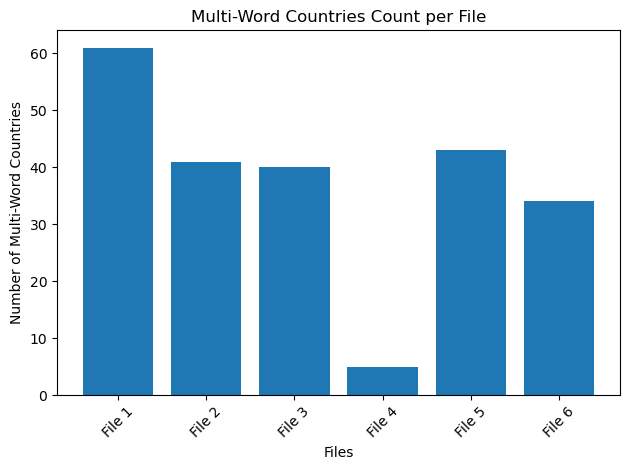

In [159]:
import re
from IPython.display import display
# Specify each file path and the column name containing country names
files_info = [
    {"file_path": "CIA World Factbook (2022).xlsx", "column_name": "Monaco"},
    {"file_path": "Change of life expectancy from 2019 to 2023.xlsx", "column_name": "Countries and territories"},
    {"file_path": "Estimate of life expectancy for various ages in 2023.xlsx", "column_name": "Locations"},
    {"file_path": "OECD (2022).xlsx", "column_name": "Country"},
    {"file_path": "World Bank Group (2022).xlsx", "column_name": "Countries and territories"},
    {"file_path": "World Health Organization (2019).xlsx", "column_name": "Countries"}
]

multi_word_counts = []  # To store count of multi-word countries per file
for idx, info in enumerate(files_info, 1):
    file_path = info["file_path"]
    column_name = info["column_name"]
    df = pd.read_excel(file_path)
    countries = df[column_name].dropna().tolist()
    multi_word_countries = [country for country in countries if re.search(r'\s', str(country))] # Extract countries with more than one word
    # Display the result in a table
    print(f"\n File {idx}: {file_path}")
    print(f"Countries with more than one word:")
    result_df = pd.DataFrame(multi_word_countries, columns=["Multi Word Countries"])
    display(result_df)
    # Append the count of multi-word countries to the list
    multi_word_counts.append(len(multi_word_countries))

# Plot the result
file_names = [f"File {idx}" for idx in range(1, len(files_info) + 1)]
plt.bar(file_names, multi_word_counts)
plt.xlabel("Files")
plt.ylabel("Number of Multi-Word Countries")
plt.title("Multi-Word Countries Count per File")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# start of analysis

In [160]:
sh1 = pd.read_excel(r"Change of life expectancy from 2019 to 2023.xlsx")
print(sh1.dtypes)
pd.DataFrame(sh1)

Countries and territories             object
All                                  float64
Male                                 float64
Female                               float64
Sex gap                              float64
2019                                 float64
2019:2020                            float64
2020                                 float64
2020:2021                            float64
2021                                 float64
2021:2022                            float64
2022                                 float64
2022:2023                            float64
2023                                 float64
Recovery from COVID-19: 2019:2023    float64
dtype: object


,Countries and territories,All,Male,Female,Sex gap,2019,2019:2020,2020,2020:2021,2021,2021:2022,2022,2022:2023,2023,Recovery from COVID-19: 2019:2023
0,"Hong Kong, China",85.51,82.84,88.13,5.29,85.26,0.56,84.71,0.38,85.08,1.60,83.48,2.03,85.51,0.25
1,Japan,84.71,81.69,87.74,6.05,84.42,0.25,84.67,0.12,84.55,0.50,84.05,0.66,84.71,0.29
2,South Korea,84.33,81.19,87.16,5.96,83.69,0.01,83.67,0.18,83.85,1.12,82.73,1.60,84.33,0.64
3,French Polynesia,84.07,81.78,86.50,4.73,83.19,0.74,82.46,2.89,79.57,4.29,83.86,0.21,84.07,0.88
4,Andorra,84.04,82.10,86.11,4.01,84.10,4.68,79.42,2.91,82.33,1.69,84.02,0.03,84.04,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,South Sudan,57.62,54.64,60.63,5.99,58.13,0.48,57.65,0.60,57.05,0.16,57.20,0.41,57.62,0.51
207,CAR,57.41,55.26,59.29,4.03,31.53,19.07,50.60,10.32,40.28,21.46,18.82,38.59,57.41,25.88
208,Lesotho,57.38,54.62,60.01,5.39,55.25,0.12,55.13,0.92,54.21,2.60,56.81,0.56,57.38,2.13
209,Chad,55.07,53.20,57.01,3.82,52.99,0.09,53.08,0.05,53.14,1.39,54.53,0.54,55.07,2.08


In [161]:
top5_2023 = sh1[['Countries and territories', '2023']].sort_values(by='2023', ascending=False).head(5)
print(top5_2023)
top5_names = pd.DataFrame(top5_2023['Countries and territories'].tolist())
print(top5_names)

  Countries and territories   2023
0          Hong Kong, China  85.51
1                     Japan  84.71
2               South Korea  84.33
3          French Polynesia  84.07
4                   Andorra  84.04
                  0
0  Hong Kong, China
1             Japan
2       South Korea
3  French Polynesia
4           Andorra


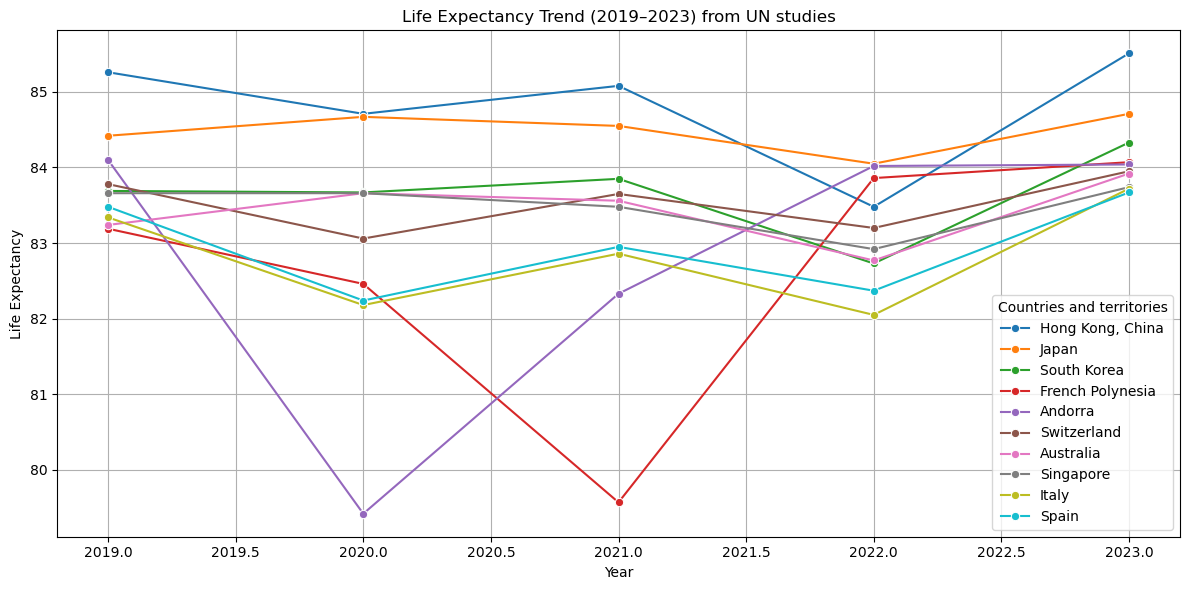

In [162]:
years = ['2019', '2020', '2021', '2022', '2023']

# convert into Long Format
df_long = sh1.melt(id_vars=['Countries and territories'],
                  value_vars=years,
                  var_name='Year',
                  value_name='Life Expectancy')

# convert year into integet
df_long['Year'] = df_long['Year'].astype(int)

# the top 5 countries
top5 = sh1[['Countries and territories', '2023']].sort_values(by='2023', ascending=False).head(10)
top5_names = top5['Countries and territories'].tolist()

df_top5 = df_long[df_long['Countries and territories'].isin(top5_names)]

# the time line
plt.figure(figsize=(12,6))
sns.lineplot(data=df_top5, x='Year', y='Life Expectancy', hue='Countries and territories', marker='o')
plt.title("Life Expectancy Trend (2019–2023) from UN studies")
plt.grid(True)
plt.tight_layout()
plt.show()

In [163]:
## the countries with high recovery after COVID-19

Fully_Recovered_UN = sh1[sh1[ "Recovery from COVID-19: 2019:2023"]>np.mean(sh1[ "Recovery from COVID-19: 2019:2023"])]
print(f"Countries with high recovery rates = {Fully_Recovered_UN[ "Recovery from COVID-19: 2019:2023"].count()} country ")
Fully_Recovered_UN[["Countries and territories","Recovery from COVID-19: 2019:2023"]]


Countries with high recovery rates = 62 country 


,Countries and territories,Recovery from COVID-19: 2019:2023
10,Réunion,1.23
25,Bermuda,1.06
42,Maldives,1.33
47,Cayman Islands,1.31
53,Panama,1.08
...,...,...
205,Somalia,1.57
207,CAR,25.88
208,Lesotho,2.13
209,Chad,2.08


In [164]:
## the countries with low recovery after COVID-19

Not_Recovered_UN =sh1[sh1[ "Recovery from COVID-19: 2019:2023"]<np.mean(sh1[ "Recovery from COVID-19: 2019:2023"])]
print(f"Countries with low recovery rates = {Not_Recovered_UN[ "Recovery from COVID-19: 2019:2023"].count()} country ")
Not_Recovered_UN[["Countries and territories","Recovery from COVID-19: 2019:2023"]]


Countries with low recovery rates = 149 country 


,Countries and territories,Recovery from COVID-19: 2019:2023
0,"Hong Kong, China",0.25
1,Japan,0.29
2,South Korea,0.64
3,French Polynesia,0.88
4,Andorra,0.06
...,...,...
192,Madagascar,0.13
196,Liberia,0.93
201,Burkina Faso,0.91
202,Benin,0.89


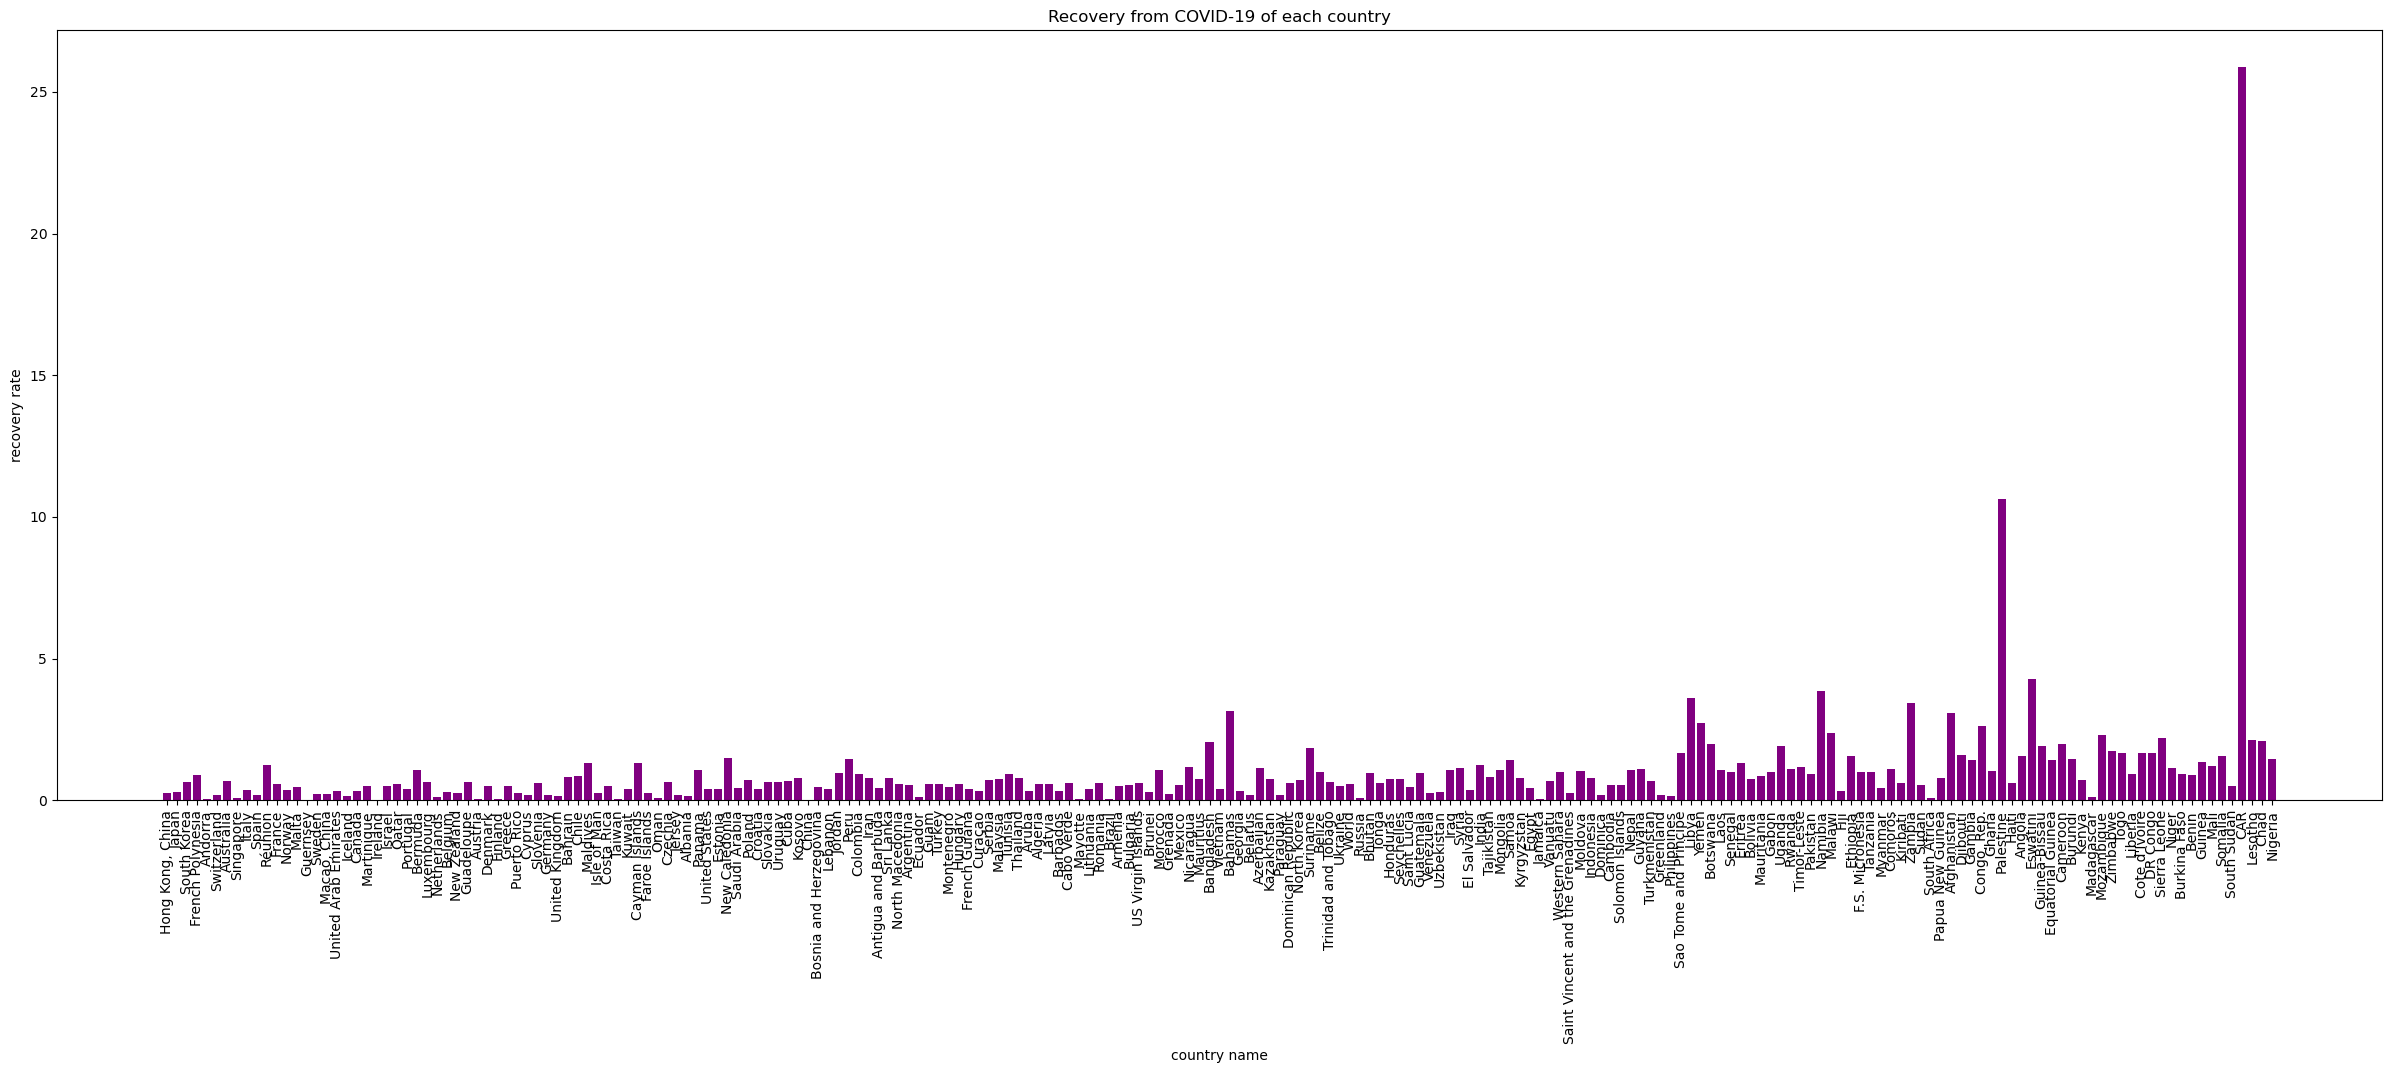

In [165]:
plt.figure(figsize=(30,10))
plt.bar(x=sh1["Countries and territories"] , height=sh1["Recovery from COVID-19: 2019:2023"] , color= "purple")
plt.title("Recovery from COVID-19 of each country")
plt.xlabel("country name")
plt.ylabel("recovery rate")
plt.xticks(rotation=90)
plt.show()

In [166]:
sh4= pd.read_excel(r"World Bank Group (2022).xlsx")
sh4

,Countries and territories,All,Male,Female,Sex gap,2014,2014:2019,2019,2019:2020,2020,2020:2021,2021,2021:2022,2022,2022:2023,2023,recovery from COVID-19: 2019:2022
0,"Hong Kong SAR, China",85.25,82.54,88.09,5.55,83.94,1.22,85.16,0.34,85.50,0.04,85.53,1.87,83.66,1.59,85.25,0.09
1,French Polynesia,84.07,81.78,86.50,4.73,82.15,1.04,83.19,0.74,82.46,2.89,79.57,4.29,83.86,0.21,84.07,0.88
2,Switzerland,84.06,82.30,85.90,3.60,83.20,0.71,83.90,0.90,83.00,0.75,83.75,0.15,83.60,0.45,84.06,0.15
3,Japan,84.04,81.09,87.14,6.05,83.59,0.77,84.36,0.20,84.56,0.11,84.45,0.45,84.00,0.04,84.04,0.32
4,Andorra,84.04,82.10,86.11,4.01,84.48,0.39,84.10,4.68,79.42,2.91,82.33,1.69,84.02,0.02,84.04,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,South Sudan,57.62,54.64,60.63,5.99,45.62,12.50,58.13,0.48,57.65,0.60,57.05,0.16,57.20,0.41,57.62,0.51
202,Central African Republic,57.41,55.26,59.29,4.03,40.27,8.73,31.53,19.07,50.60,10.32,40.28,21.46,18.82,38.59,57.41,25.88
203,Lesotho,57.38,54.62,60.01,5.39,50.79,4.46,55.25,0.12,55.13,0.92,54.21,2.60,56.81,0.56,57.38,2.13
204,Chad,55.07,53.20,57.01,3.82,51.14,1.85,52.99,0.09,53.08,0.05,53.14,1.39,54.53,0.54,55.07,2.08


In [167]:
## countries with the highest Wiggle from2019 to 2022
sh4["2014:2022"]= sh4["2014"] - sh4["2022"]
sh4[["Countries and territories","2014:2022"]]. sort_values(by=("2014:2022") , ascending =False).head(10)

,Countries and territories,2014:2022
202,Central African Republic,21.45
91,Brunei,1.94
19,United Arab Emirates,1.50
56,USA,1.41
46,Oman,1.12
105,Paraguay,1.10
92,North Macedonia,1.03
81,Thailand,0.99
42,Costa Rica,0.91
32,Cyprus,0.91


In [168]:
## the countries with high recovery after COVID-19

Fully_Recovered_World_Bank_Group = sh4[sh4[ "recovery from COVID-19: 2019:2022"]>np.mean(sh4[ "recovery from COVID-19: 2019:2022"])]
print(f"Countries with high recovery rates = {Fully_Recovered_World_Bank_Group["recovery from COVID-19: 2019:2022"].count()} country ")
Fully_Recovered_World_Bank_Group[["Countries and territories","recovery from COVID-19: 2019:2022"]].head()

Countries with high recovery rates = 62 country 


,Countries and territories,recovery from COVID-19: 2019:2022
12,Kuwait,1.22
25,Bermuda,1.06
40,Maldives,1.33
45,Cayman Islands,1.31
49,Panama,1.08


In [169]:
## the countries with low recovery after COVID-19

Not_Recovered_World_Bank_Group = sh4[sh4[ "recovery from COVID-19: 2019:2022"]<np.mean(sh4[ "recovery from COVID-19: 2019:2022"])]
print(f"Countries with low recovery rates ={Not_Recovered_World_Bank_Group[ "recovery from COVID-19: 2019:2022"].count()} country ")
Not_Recovered_World_Bank_Group[["Countries and territories","recovery from COVID-19: 2019:2022"]]

Countries with low recovery rates =144 country 


,Countries and territories,recovery from COVID-19: 2019:2022
0,"Hong Kong SAR, China",0.09
1,French Polynesia,0.88
2,Switzerland,0.15
3,Japan,0.32
4,Andorra,0.06
...,...,...
187,Madagascar,0.13
191,Liberia,0.93
196,Burkina Faso,0.91
197,Benin,0.89


In [170]:
print("Countries with the largest sex gap according to World Bank Group studies :")
sh4[[ "Countries and territories","Sex gap" ]].sort_values(by=("Sex gap"),ascending = False).head(10)

Countries with the largest sex gap according to World Bank Group studies :


,Countries and territories,Sex gap
111,Ukraine,13.30
178,Palestine,11.81
114,Russia,10.69
90,Latvia,10.00
101,Georgia,9.54
104,Belarus,9.53
99,Vietnam,9.39
125,Mongolia,9.23
75,Lithuania,9.20
54,Estonia,9.00


## Continue of Analysis

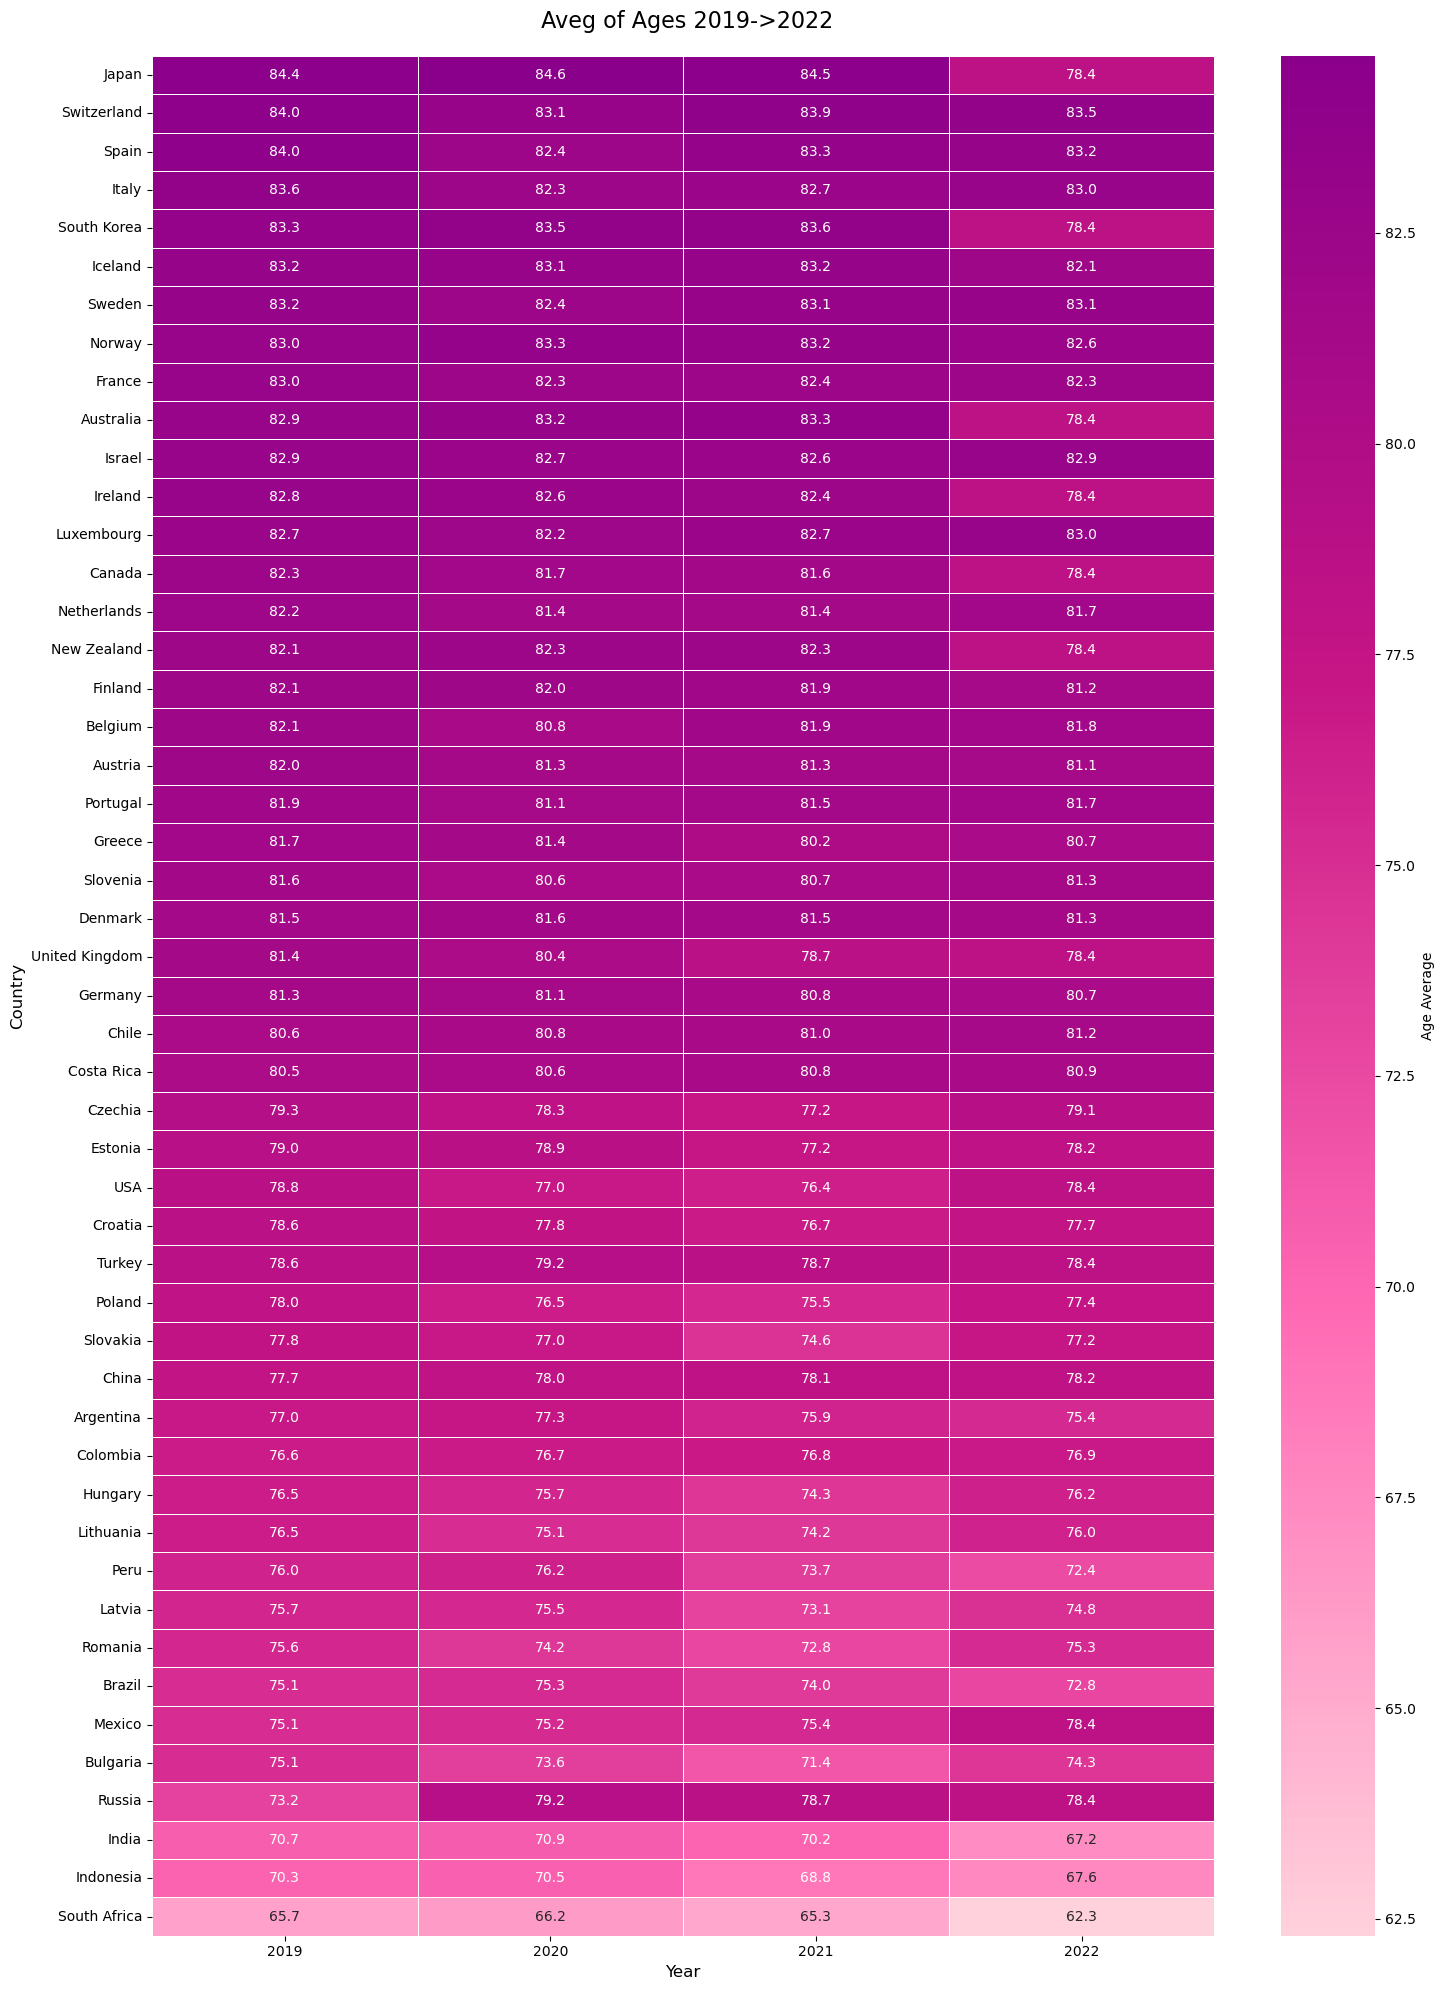

In [171]:
#(OECD sheet)
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px

# HeatMap to show the avg of ages of each country over years

df = pd.read_excel("OECD (2022).xlsx")
years = ['2019', '2020', '2021', '2022'] # select columns
data = df[['Country'] + years]
data.set_index('Country', inplace=True)
colors = ["#FFD1DC", "#FF69B4", "#C71585", "#8B008B"]  # create color pink
cmap = LinearSegmentedColormap.from_list("pink_gradient", colors)
plt.figure(figsize=(15, 20)) # create plot
sns.heatmap(data,
            annot=True,
            fmt=".1f",
            cmap=cmap,
            linewidths=0.5,
            cbar_kws={'label': 'Age Average'})
plt.title(' Aveg of Ages 2019->2022', fontsize=16, pad=20) # add titles
plt.xlabel('Year', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

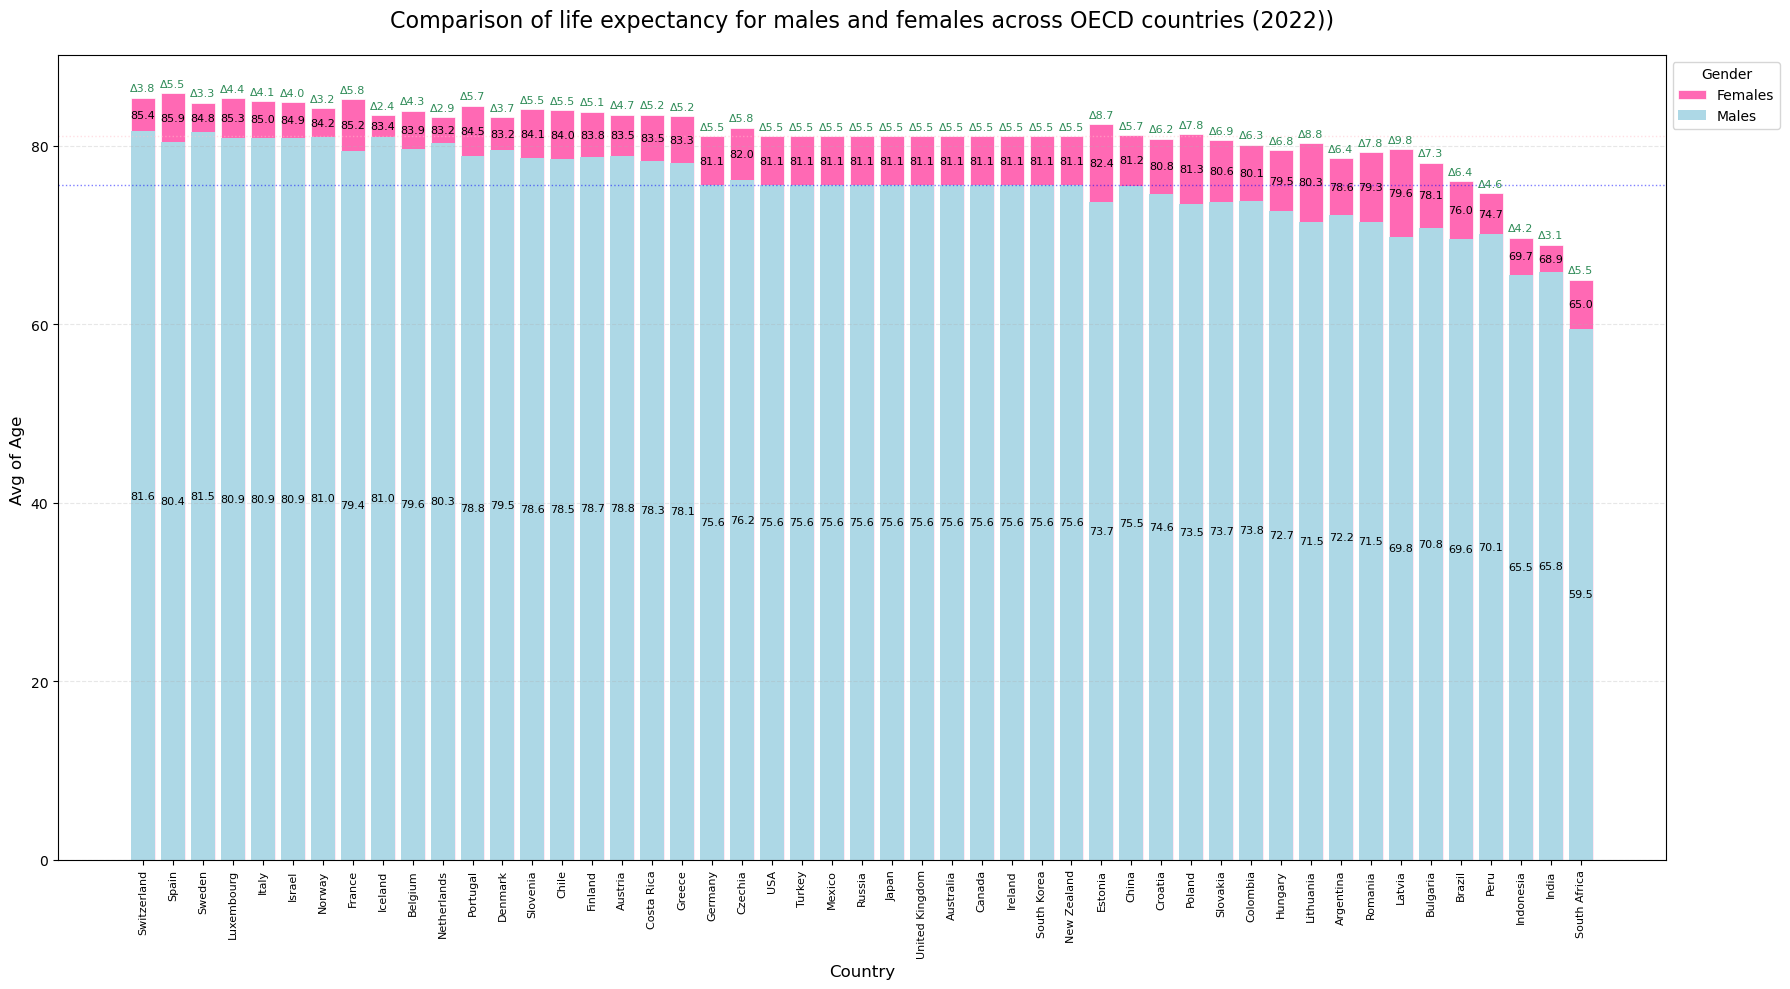

In [172]:
#Stacked bar plot for the gap between each gender
df_sorted = df.sort_values('2022overall', ascending=False) # arrange countries depend on avg of age
countries = df_sorted['Country'].values
male = df_sorted['2022male'].values
female = df_sorted['2022female'].values
plt.figure(figsize=(18, 10)) # create plots

#create stacked bars
bars = plt.bar(countries, female, color='#FF69B4', label='Females')
plt.bar(countries, male, color='#ADD8E6', label='Males')
for bar in bars:# add lines
    bar.set_edgecolor('white')
    bar.set_linewidth(0.5)
for i, (m, f) in enumerate(zip(male, female)): # add values and values of gaps
    plt.text(i, m/2, f'{m:.1f}', ha='center', va='center', color='black', fontsize=8)
    plt.text(i, m + (f-m)/2, f'{f:.1f}', ha='center', va='center', color='black', fontsize=8)
    gap = f - m  #calculate gap
    plt.text(i, f + 0.5, f'Δ{gap:.1f}', ha='center', va='bottom', color='#2E8B57', fontsize=8)

plt.title('Comparison of life expectancy for males and females across OECD countries (2022))', fontsize=16, pad=20)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Avg of Age ', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Gender', bbox_to_anchor=(1, 1), loc='upper left')
avg_male = df['2022male'].mean() #line of mean of the year
avg_female = df['2022female'].mean()
plt.axhline(avg_male, color='blue', linestyle=':', linewidth=1, alpha=0.5)
plt.axhline(avg_female, color='pink', linestyle=':', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.show()

In [173]:
# analysis on (World Health Organization table)
# create a world map to show the countries of best health care and the worst
df = pd.read_excel("World Health Organization (2019).xlsx")
df_clean = df.dropna(subset=['All']).copy()
df_clean = df_clean.rename(columns={'Countries': 'Country'})
orange_palette = ["#FFF5EB", "#FEE6CE", "#FDD0A2", "#FDAE6B", "#FD8D3C", "#F16913", "#D94801", "#A63603", "#7F2704"] #orange color
fig = px.choropleth(df_clean,
                    locations="Country",
                    locationmode="country names",
                    color="All",
                    hover_name="Country",
                    hover_data=["All", "Δ2000"],
                    color_continuous_scale=orange_palette,
                    range_color=(50, 85),
                    title="<b>خريطة متوسط العمر العالمي (2019)</b><br><sup>تدرج لوني من الأدنى (فاتح) إلى الأعلى (غامق)</sup>",
                    labels={'All': 'متوسط العمر'})
fig.update_layout(geo=dict(showframe=False,
                          showcoastlines=True,
                          projection_type='natural earth'),
                 margin=dict(l=0, r=0, t=50, b=0))
fig.show()


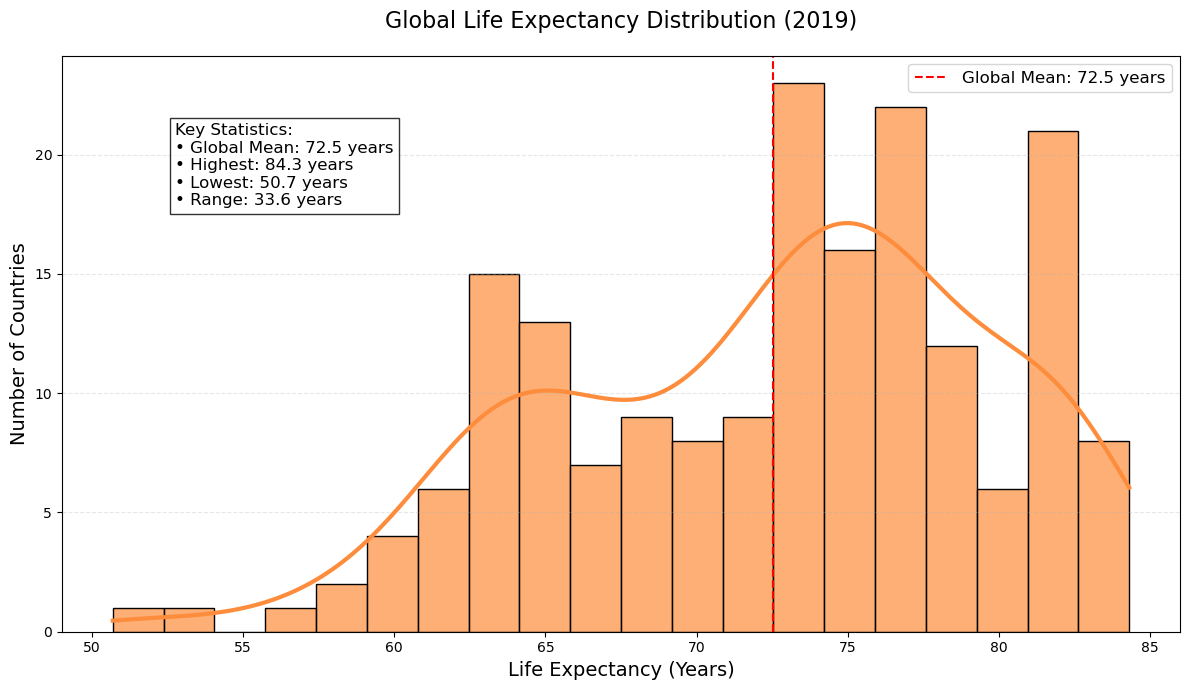

In [174]:

# histogram to show the distribution of avg of ages
df_clean = df.rename(columns={'Countries': 'Country'}).dropna(subset=['All'])
plt.figure(figsize=(12, 7))
# Plot distribution with KDE
ax = sns.histplot(data=df_clean, x='All', bins=20,
                 kde=True, color='#FD8D3C',
                 alpha=0.7, line_kws={'lw': 3})
global_mean = df_clean['All'].mean() # add line of global mean
plt.axvline(global_mean, color='red', linestyle='--',
           label=f'Global Mean: {global_mean:.1f} years')
plt.title('Global Life Expectancy Distribution (2019)', fontsize=16, pad=20)
plt.xlabel('Life Expectancy (Years)', fontsize=14)
plt.ylabel('Number of Countries', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
# Add statistics box
stats_text = f"""Key Statistics:
• Global Mean: {global_mean:.1f} years
• Highest: {df_clean['All'].max():.1f} years
• Lowest: {df_clean['All'].min():.1f} years
• Range: {df_clean['All'].max()-df_clean['All'].min():.1f} years"""
plt.gcf().text(0.15, 0.7, stats_text,
              bbox=dict(facecolor='white', alpha=0.8),
              fontsize=12)
plt.tight_layout()
plt.show()


------------
# Start making relationships between the tables

In [175]:
# Merging 2022 Life Expectancy Data from Multiple Sources (UN, WHO, CIA, World Bank, OECD)

# Rename columns for each source and prepare the 2022 data 
un_2022 = sh1[['Countries and territories', '2022']].rename(columns={'Countries and territories': 'Country', '2022': 'UN'})
who_2022 = sh2[['Countries', 'All.2']].rename(columns={'Countries': 'Country', 'All.2': 'WHO'})
cia_2022 = sh3[[sh3.columns[0], sh3.columns[1]]].rename(columns={sh3.columns[0]: 'Country', sh3.columns[1]: 'CIA'})
wb_2022 = sh4[['Countries and territories', '2022']].rename(columns={'Countries and territories': 'Country', '2022': 'World_Bank'})
oecd_2022 = sh6[['Country', '2022']].rename(columns={'2022': 'OECD'})

# Merge all data sources on Country column 
all_2022 = un_2022
for df in [who_2022, cia_2022, wb_2022, oecd_2022]:
    all_2022 = pd.merge(all_2022, df, on='Country', how='outer')

# Drop rows with any missing values 
all_2022 = all_2022.dropna()

print("2022 data from all sources: ")
print(all_2022.head(10))


2022 data from all sources: 
       Country     UN   WHO    CIA  World_Bank       OECD
8    Argentina  75.81  21.1  78.31       75.81  75.400000
11   Australia  82.77  25.6  83.09       83.20  78.376316
12     Austria  81.30  24.1  82.27       81.30  81.100000
19     Belgium  81.16  24.0  81.86       81.75  81.800000
27      Brazil  74.87  21.9  75.92       74.87  72.800000
31    Bulgaria  74.03  19.8  75.57       74.16  74.300000
39      Canada  81.25  25.2  83.80       81.25  78.376316
45       Chile  79.18  24.3  79.79       79.18  81.200000
47    Colombia  76.51  24.0  74.89       76.51  76.900000
53  Costa Rica  79.32  25.0  79.64       79.32  80.900000


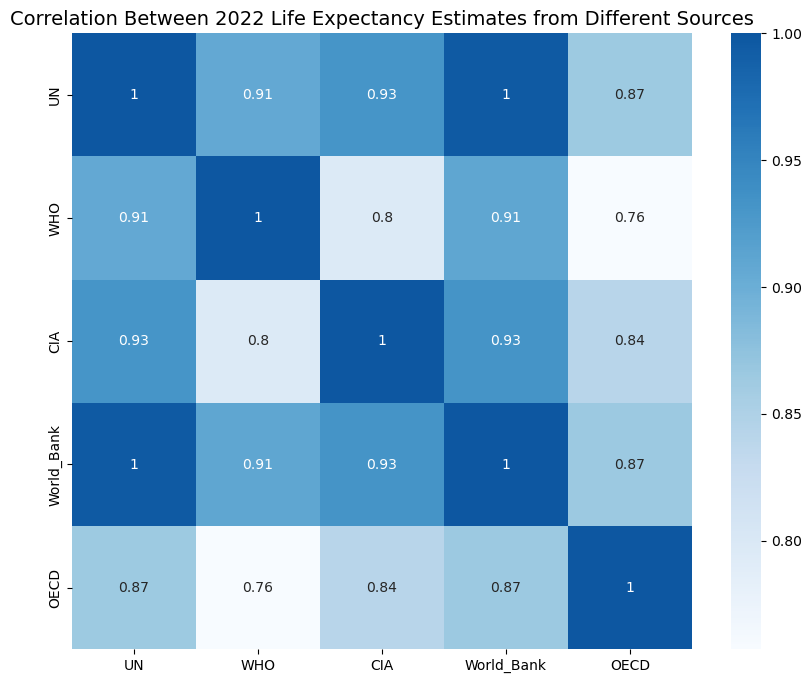

In [176]:
# heatmap shows the degree of correlation between different sources reporting 2022 life expectancy

# Drop rows with too many missing values && keep rows with at least all but 2 columns filled
clean_2022 = all_2022.dropna(thresh=len(all_2022.columns) - 2)

# Create a correlation matrix between numeric columns 
corr_matrix = clean_2022.drop('Country', axis=1).corr()

# Plot the heatmap showing correlations between life expectancy estimates 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', center=0.9)
plt.title('Correlation Between 2022 Life Expectancy Estimates from Different Sources', fontsize=14)
plt.show()


In [177]:
# Filtering Countries with High Recovery Rates in Life Expectancy and Checking for Full Recovery

# Merge data from two sources on country names 
merged_data = pd.merge(
    sh1[['Countries and territories', '2019', '2023', 'Recovery from COVID-19: 2019:2023']],
    sh4[['Countries and territories', '2019', 'recovery from COVID-19: 2019:2022']],
    on='Countries and territories',
    how='inner'
)

# Filter countries with high recovery in life expectancy , more than 90% 
high_recovery = merged_data[merged_data['Recovery from COVID-19: 2019:2023'] > 0.9]

# Add a boolean column indicating if 2023 life expectancy reached or surpassed 2019 
high_recovery['Recovered_to_2019_or_higher'] = high_recovery['2023'] >= high_recovery['2019_x']

high_recovery[['Countries and territories', '2019_x', '2023', 
               'Recovery from COVID-19: 2019:2023', 'Recovered_to_2019_or_higher']]



C:\Users\original\AppData\Local\Temp\ipykernel_3912\2658718187.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Countries and territories,2019_x,2023,Recovery from COVID-19: 2019:2023,Recovered_to_2019_or_higher
20,Bermuda,81.25,82.31,1.06,True
36,Maldives,79.71,81.04,1.33,True
40,Cayman Islands,79.05,80.36,1.31,True
45,Panama,78.51,79.59,1.08,True
47,New Caledonia,77.26,78.77,1.50,True
...,...,...,...,...,...
186,Mali,59.22,60.44,1.22,True
187,Somalia,57.25,58.82,1.57,True
189,Lesotho,55.25,57.38,2.13,True
190,Chad,52.99,55.07,2.08,True


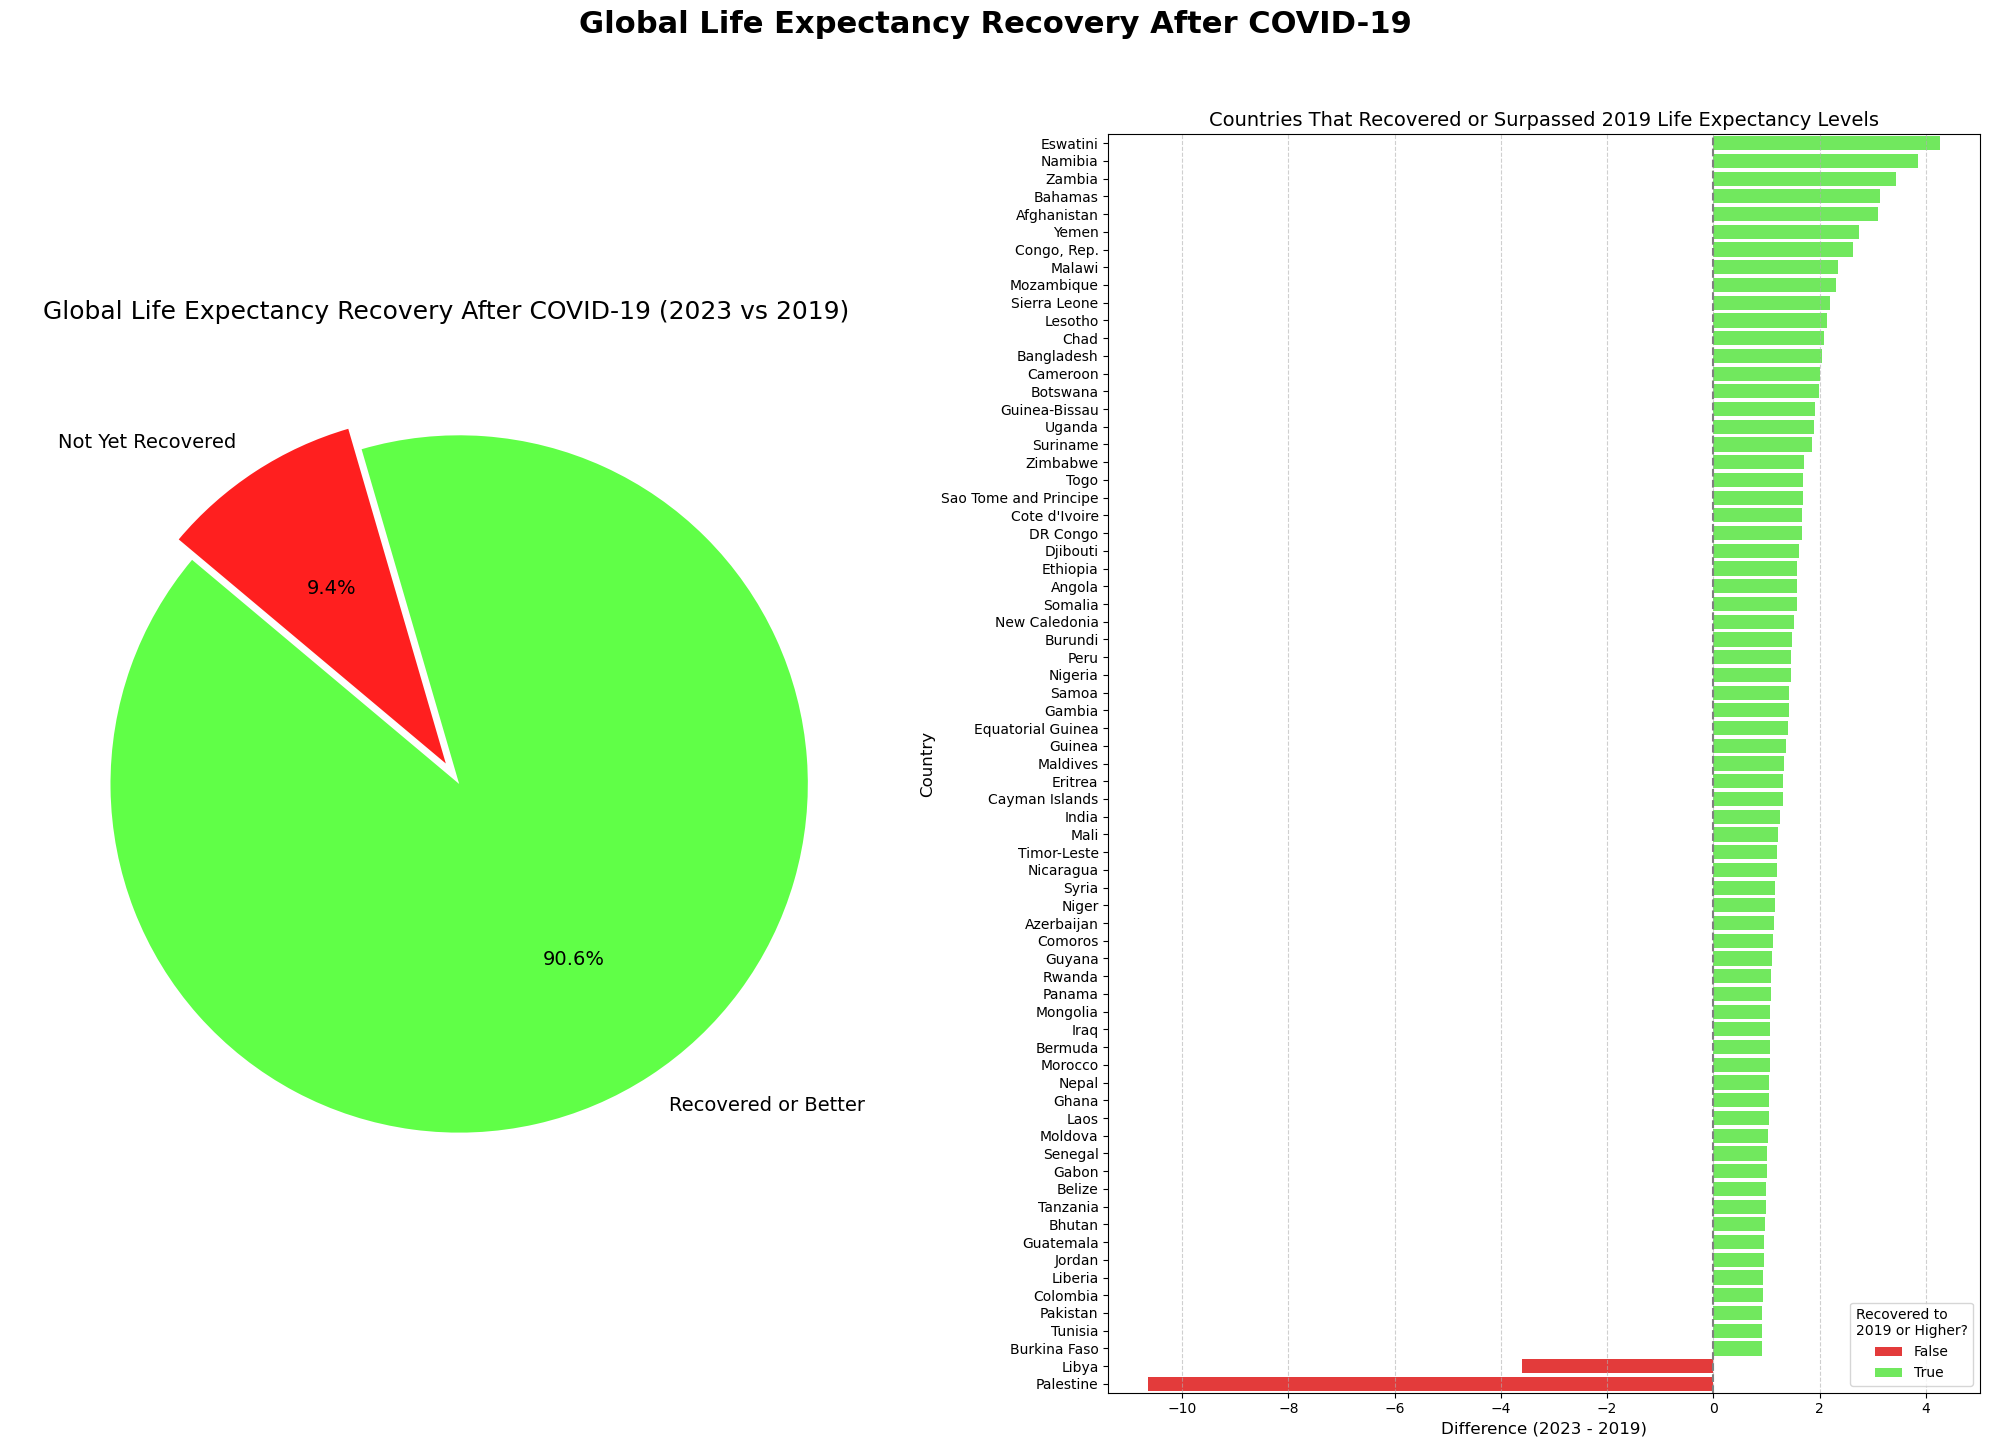

In [178]:
# Create subplots for pie chart and bar chart 
fig, ax = plt.subplots(1, 2, figsize=(20, 14))

# Classify countries based on they've recovered to 2019 levels or not
recovered_countries = merged_data[merged_data['2023'] >= merged_data['2019_x']]
not_recovered_countries = merged_data[merged_data['2023'] < merged_data['2019_x']]

# Calculate the percentage of recovered countries 
total = len(merged_data)
recovered_pct = (len(recovered_countries) / total) * 100
not_recovered_pct = 100 - recovered_pct

# Set the overall figure title 
fig.suptitle("Global Life Expectancy Recovery After COVID-19", fontsize=22, fontweight='bold', y=1.03)

# Pie Chart: Show proportion of recovered vs not recovered countries 
labels = ['Recovered or Better', 'Not Yet Recovered']
sizes = [recovered_pct, not_recovered_pct]
colors = ['#60ff47', '#ff1f1f']
explode = (0.07, 0)  # Slightly explode the recovered slice

ax[0].pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 14}
)
ax[0].set_title("Global Life Expectancy Recovery After COVID-19 (2023 vs 2019)", fontsize=18)

# Bar Chart: Show countries and how much they recovered or not
plot_data = high_recovery.copy()
plot_data['Difference'] = plot_data['2023'] - plot_data['2019_x']
plot_data = plot_data.sort_values(by='Difference', ascending=False)

sns.barplot(
    data=plot_data,
    x='Difference',
    y='Countries and territories',
    hue='Recovered_to_2019_or_higher',
    dodge=False,
    palette={True: '#60ff47', False: '#ff1f1f'},
    ax=ax[1]
)

ax[1].set_title("Countries That Recovered or Surpassed 2019 Life Expectancy Levels", fontsize=14)
ax[1].set_xlabel('Difference (2023 - 2019)', fontsize=12)
ax[1].set_ylabel('Country', fontsize=12)
ax[1].axvline(0, color='gray', linestyle='--')  
ax[1].legend(title='Recovered to \n2019 or Higher?', loc='lower right')
ax[1].grid(True, axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


                Country  UN (Sex gap)  WHO (FΔM)
1               Albania          3.72        3.6
119    Papua New Guinea          5.35        4.0
173              Zambia          4.74        5.9
38               Cyprus          4.03        4.0
0           Afghanistan          3.07        0.1
158               Tonga          7.04        5.8
149            Suriname          6.38        6.1
62        Guinea-Bissau          4.71        5.6
73               Israel          4.41        3.6
91           Madagascar          3.44        2.5
68                India          3.08        2.7
64                Haiti          6.57        1.5
93             Malaysia          5.10        4.5
80             Kiribati          3.59        6.7
94             Maldives          3.13        2.2
16               Belize          5.57        6.4
26           Cabo Verde          6.35        8.0
39              Denmark          3.84        3.4
79                Kenya          4.46        4.7
89            Lithua

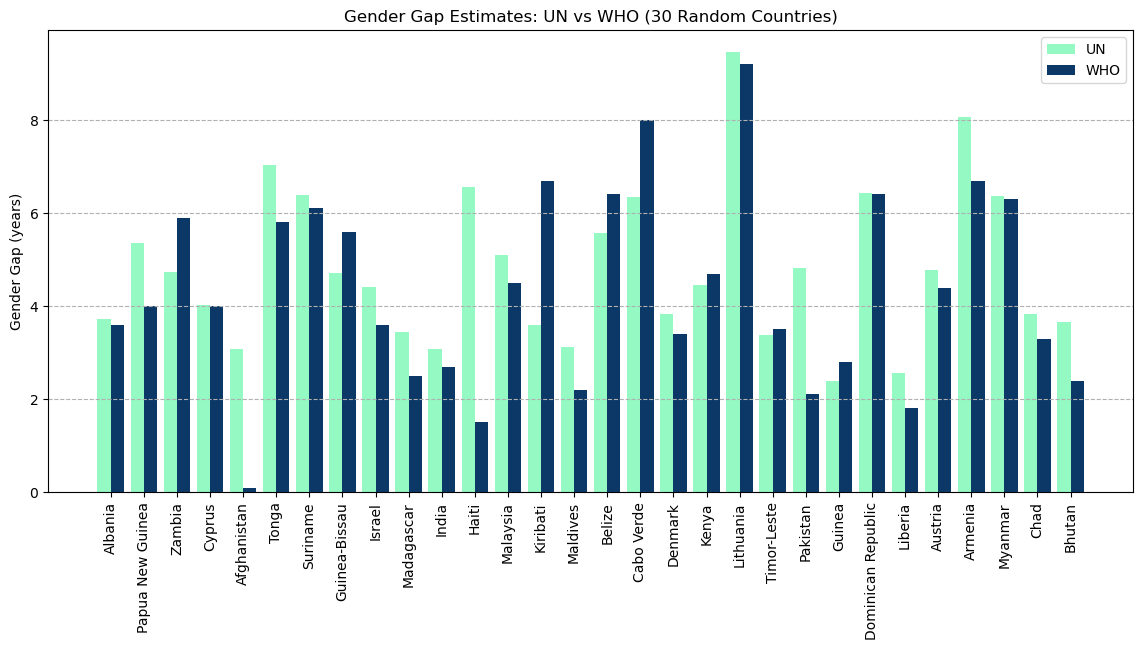

In [179]:
# Comparing Gender Gap Estimates in Life Expectancy from UN and WHO Across 30 Random Countries

# Extract the common countries between the two datasets 
common_countries = set(sh1['Countries and territories']).intersection(set(sh2['Countries']))
common_countries = sorted(common_countries)

# Extract the sex gap values from both UN and WHO datasets for common countries 
results = []
for country in common_countries:
    un_gap = sh1.loc[sh1['Countries and territories'] == country, 'Sex gap'].values[0]
    who_gap = sh2.loc[sh2['Countries'] == country, 'FΔM'].values[0]
    results.append({'Country': country, 'UN (Sex gap)': un_gap, 'WHO (FΔM)': who_gap})

#Convert it into a DataFrame 
df = pd.DataFrame(results)

#Select a random sample of 30 countries for visualization 
random_gap = df.sample(30)
print(random_gap[['Country', 'UN (Sex gap)', 'WHO (FΔM)']])

plt.figure(figsize=(14, 6))
x = np.arange(len(random_gap['Country']))

# Bar plot for UN data
plt.bar(x - 0.2, random_gap['UN (Sex gap)'], 0.4, label='UN', color='#95f9c3')

# Bar plot for WHO data
plt.bar(x + 0.2, random_gap['WHO (FΔM)'], 0.4, label='WHO', color='#0b3866')

# Customize x-axis
plt.xticks(x, random_gap['Country'], rotation=90)

# Add title and labels
plt.title('Gender Gap Estimates: UN vs WHO (30 Random Countries)')
plt.ylabel('Gender Gap (years)')

# Add legend and grid
plt.legend()
plt.grid(axis='y', linestyle='--')

plt.show()


In [180]:
#Calculating and Ranking the Countries Most Affected by COVID-19 in Terms of Life Expectancy Decline (2019–2022)

# Select and rename relevant columns from the dataframe
covid_impact = sh2[['Countries', 'All', 'All.1']].rename(
    columns={
        'All': 'At_Birth_2019',
        'All.1': 'At_Birth_2022'
    }
)

# Calculate the decline in life expectancy between 2019 and 2022 
covid_impact['Decline'] = covid_impact['At_Birth_2019'] - covid_impact['At_Birth_2022']

# Sort countries by the amount of decline (highest first) and select top 20 
top_decline = covid_impact.sort_values('Decline', ascending=False).head(20)

# Display it 
top_decline.sort_values('Decline', ascending=False).head(20)

,Countries,At_Birth_2019,At_Birth_2022,Decline
39,United States of America,78.5,66.1,12.4
7,Australia,83.0,70.9,12.1
15,New Zealand,82.0,70.2,11.8
24,United Kingdom,81.4,70.1,11.3
9,Norway,82.6,71.4,11.2
4,Spain,83.2,72.1,11.1
6,Italy,83.0,71.9,11.1
48,Iran,77.3,66.3,11.0
28,Kuwait,81.0,70.1,10.9
14,Canada,82.2,71.3,10.9


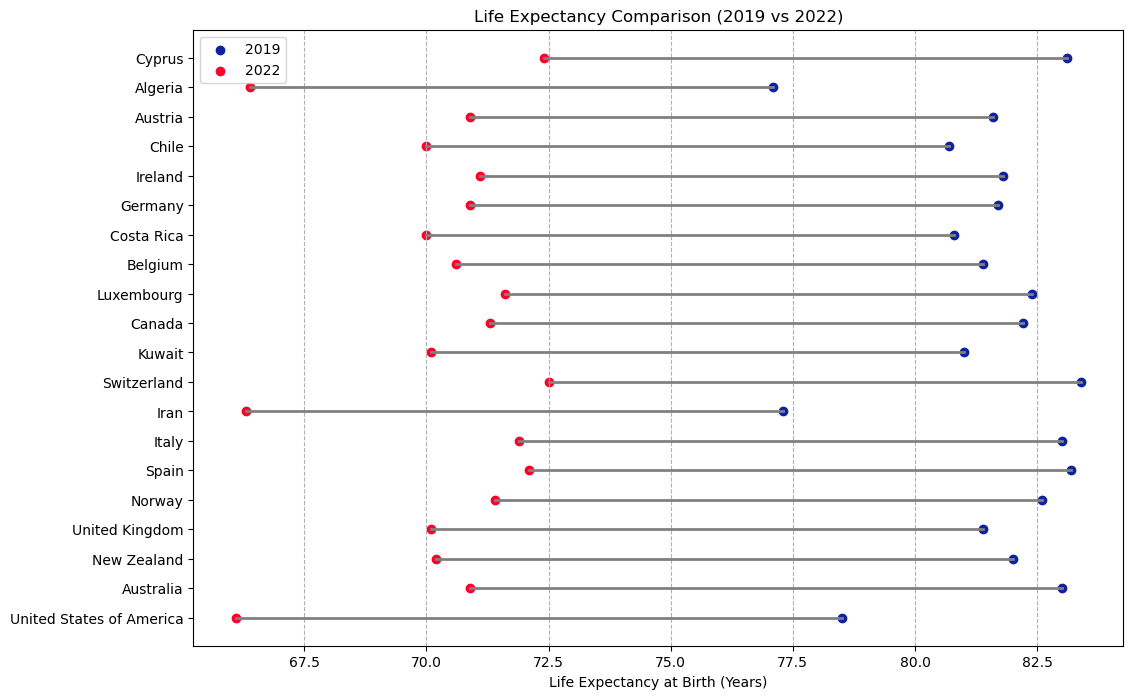

In [181]:
# Visualizing the Largest Declines in Life Expectancy at Birth (2019 vs 2022)

plt.figure(figsize=(12, 8))
for i in range(len(top_decline)):
    plt.plot([top_decline['At_Birth_2019'].iloc[i], top_decline['At_Birth_2022'].iloc[i]], [i, i], color='gray', linewidth=2)
    plt.scatter(top_decline['At_Birth_2019'].iloc[i], i, color='#0d21a1', label='2019' if i == 0 else "")
    plt.scatter(top_decline['At_Birth_2022'].iloc[i], i, color='#ff002b', label='2022' if i == 0 else "")
# Set y-axis labels to country names
plt.yticks(range(len(top_decline)), top_decline['Countries'])
plt.xlabel('Life Expectancy at Birth (Years)')
plt.title('Life Expectancy Comparison (2019 vs 2022)')
plt.grid(axis='x', linestyle='--')
plt.legend()
plt.show()


C:\Users\original\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



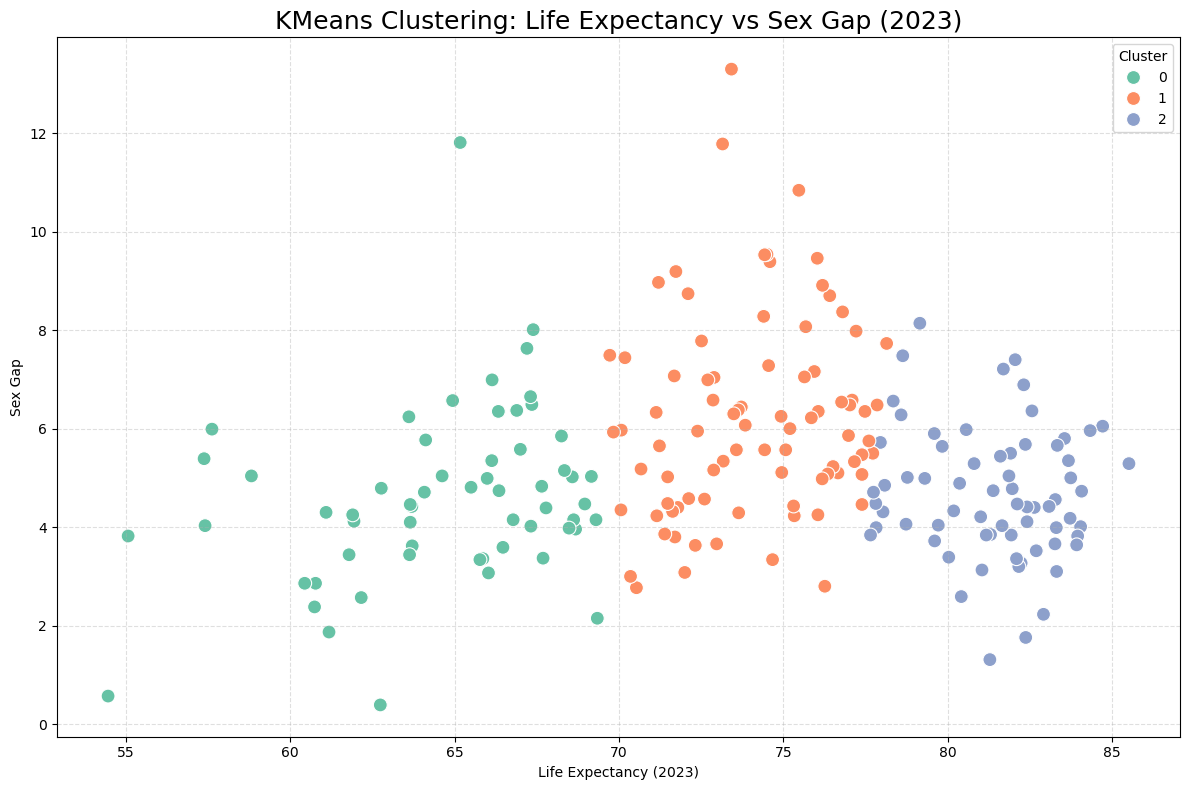

,Cluster 0,Cluster 1,Cluster 2
0,Libya,Uruguay,"Hong Kong, China"
1,Yemen,Bosnia and Herzegovina,Japan
2,Botswana,Colombia,South Korea
3,Laos,Antigua and Barbuda,French Polynesia
4,Senegal,Sri Lanka,Andorra
...,...,...,...
79,NaN,Guyana,NaN
80,NaN,Turkmenistan,NaN
81,NaN,Greenland,NaN
82,NaN,Philippines,NaN


In [182]:
# Clustering Countries Based on Life Expectancy, COVID-19 Recovery, and Sex Gap (KMeans Analysis) 

cluster_data = sh1[['2023', 'Recovery from COVID-19: 2019:2023', 'Sex gap']]
kmeans = KMeans(n_clusters=3)
# Visualize the clusters
sh1['Cluster'] = kmeans.fit_predict(cluster_data)
plt.figure(figsize=(12, 8))
sns.scatterplot(data=sh1, x='2023', y='Sex gap', hue='Cluster', palette='Set2', s=100)
plt.title('KMeans Clustering: Life Expectancy vs Sex Gap (2023)', fontsize=18)
plt.xlabel('Life Expectancy (2023)')
plt.ylabel('Sex Gap')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()
# Group countries by cluster and display the results
clusters = sh1[['Countries and territories', 'Cluster']]
cluster_groups = clusters.groupby('Cluster')['Countries and territories'].apply(list)

cluster_df = pd.DataFrame({f'Cluster {i}': pd.Series(countries)
                           for i, countries in cluster_groups.items()})
display(cluster_df)


# Store the result into MongoDB

In [184]:
t1=pd.read_excel(r"Change of life expectancy from 2019 to 2023.xlsx", header=0)
t2=pd.read_excel(r"World Health Organization (2019).xlsx", header=0)
t3=pd.read_excel(r"CIA World Factbook (2022).xlsx", header=0)
t4=pd.read_excel(r"World Bank Group (2022).xlsx", header=0)
t5=pd.read_excel(r"Estimate of life expectancy for various ages in 2023.xlsx", header=0)
t6=pd.read_excel(r"OECD (2022).xlsx", header=0)


In [99]:
pip install pymongo

Note: you may need to restart the kernel to use updated packages.


In [187]:
# Import required modules
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure, BulkWriteError

try:

    # Local MongoDB connection
    client = MongoClient("mongodb://localhost:27017/", serverSelectionTimeoutMS=5000)
    db = client["LifeExpectancyDB"]

    # Test connection by sending a ping
    client.admin.command('ping')
    print("Successfully connected to MongoDB.")
    
    # List of tables to store with their collection names
    tables = [
        (t1, "Change from 2019 to 2023"),
        (t2, "World Health Organization (2019)"),
        (t3, "CIA World Factbook (2022)"),
        (t4, "World Bank Group (2022)"),
        (t5, "Estimate of life expectancy for various ages in 2023"),
        (t6, "OECD (2022)")
    ]

    # Loop through each table and store in MongoDB
    for df, name in tables:
        try:
            # Convert column names to strings to ensure compatibility
            df.columns = df.columns.map(str)

            # Convert DataFrame to dictionary records
            data = df.to_dict("records")

            # Get or create the collection
            collection = db[name]

            # Insert all records into MongoDB
            collection.insert_many(data)
            print(f"Stored {len(data)} records in collection: {name}")
            
        except BulkWriteError as e:

            # Handle bulk write errors
            print(f"Error inserting data into {name}: {e.details['writeErrors']}")
            
        except Exception as e:

            # Handle any other unexpected errors
            print(f"Unexpected error with {name}: {str(e)}")

except ConnectionFailure as e:

    # Handle connection failures
    print(f"Could not connect to MongoDB: {str(e)}")
    
except Exception as e:

    # Handle any other unexpected errors
    print(f"Unexpected error: {str(e)}")
    
finally:
    # Ensure connection is closed even if errors occur
    client.close()

Successfully connected to MongoDB.
Stored 211 records in collection: Change from 2019 to 2023
Stored 184 records in collection: World Health Organization (2019)
Stored 228 records in collection: CIA World Factbook (2022)
Stored 206 records in collection: World Bank Group (2022)
Stored 211 records in collection: Estimate of life expectancy for various ages in 2023
Stored 49 records in collection: OECD (2022)
